/Users/lihongxuan/miniconda3/envs/icl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/lihongxuan/miniconda3/envs/icl/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
Generating test split: 100%|██████████| 173601/173601 [00:00<00:00, 1579383.70 examples/s]
`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the ar

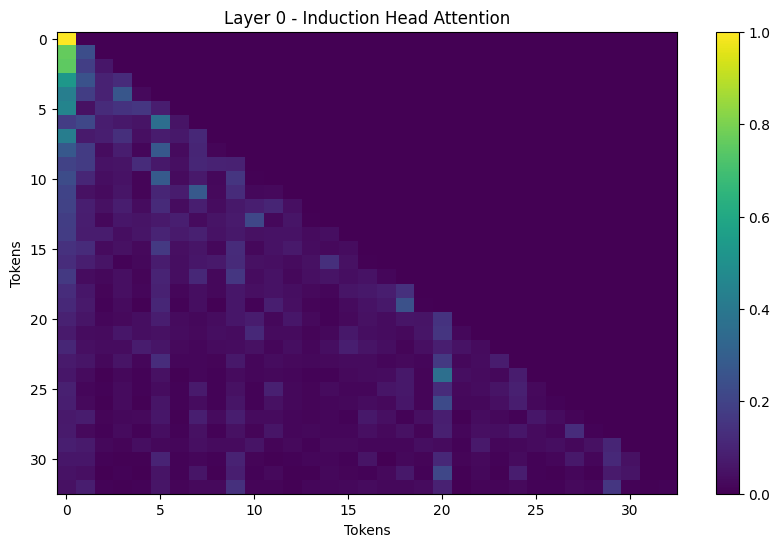

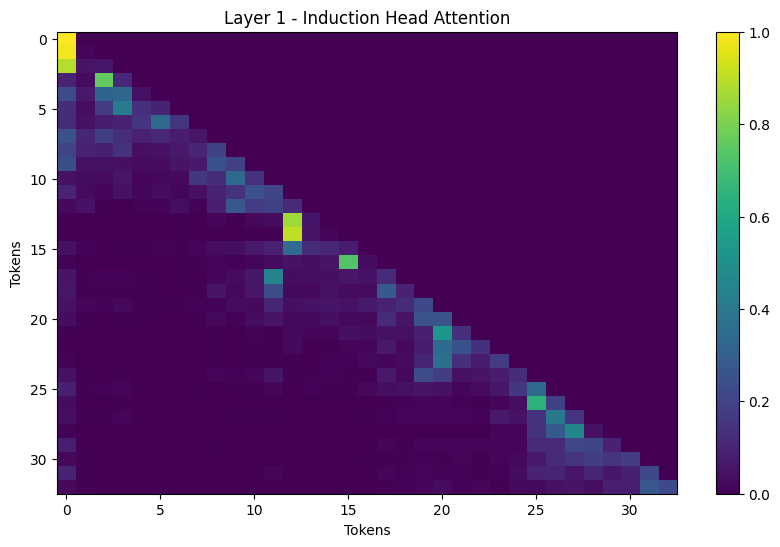

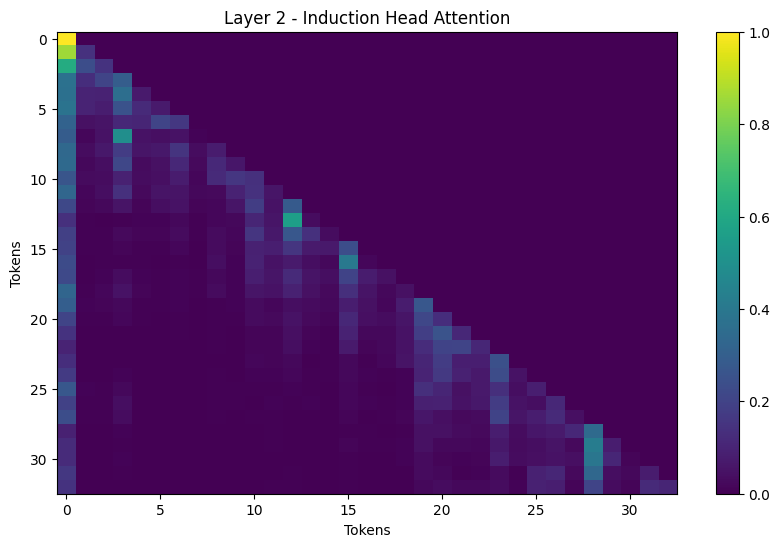

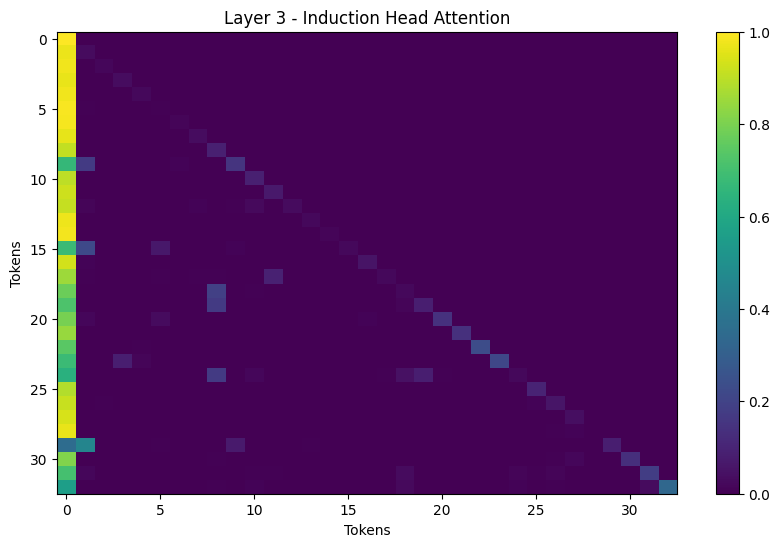

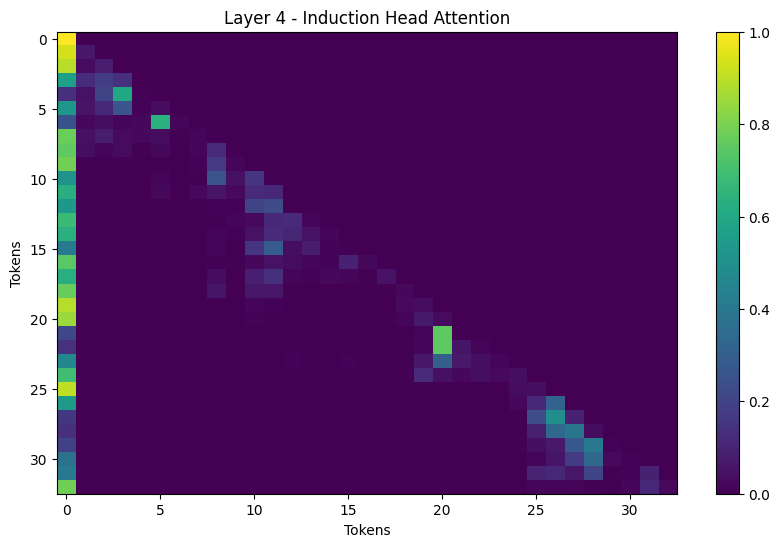

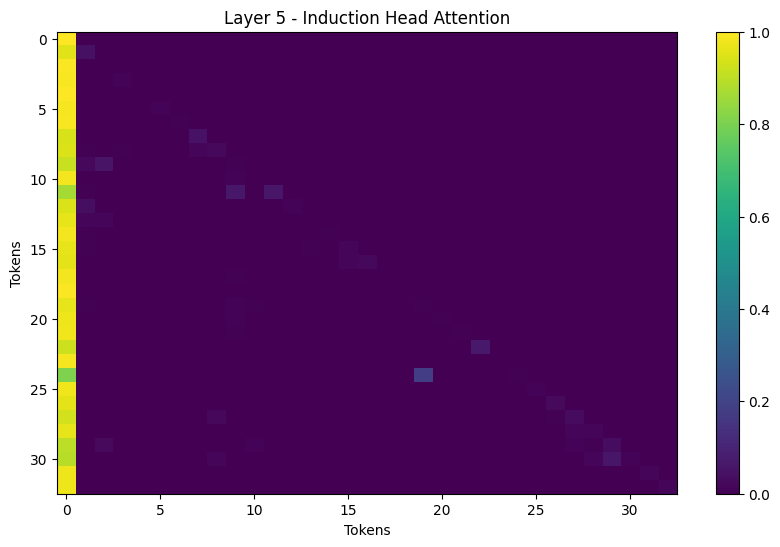

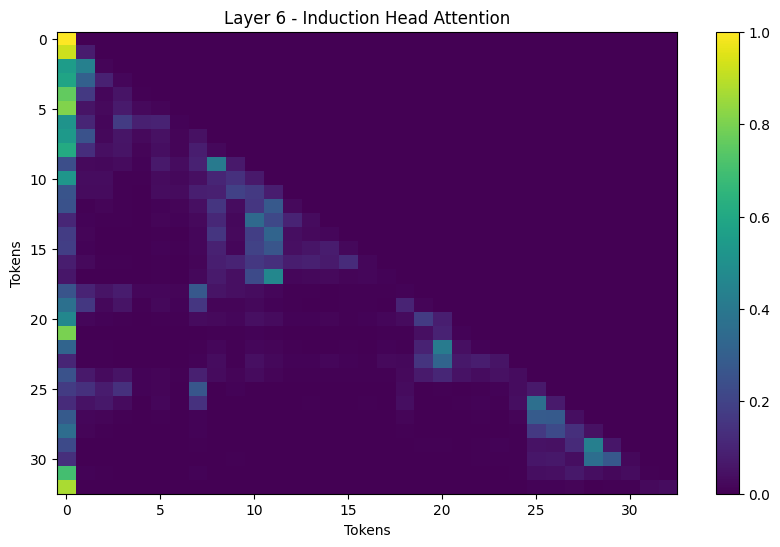

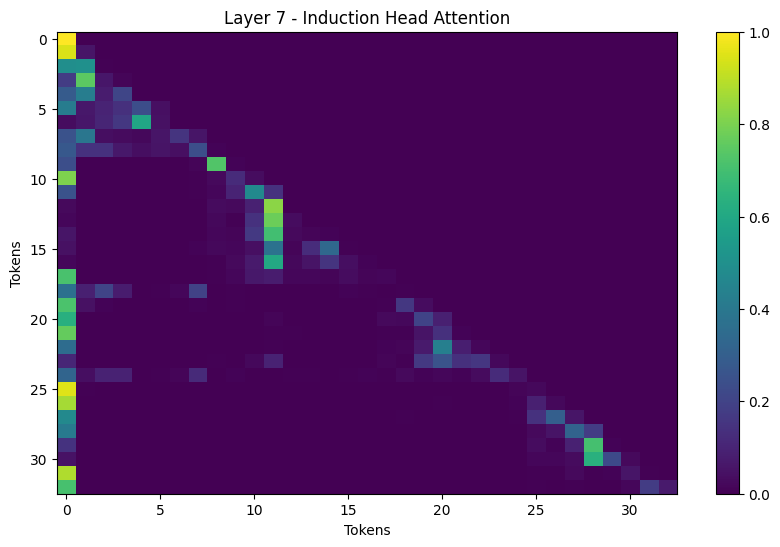

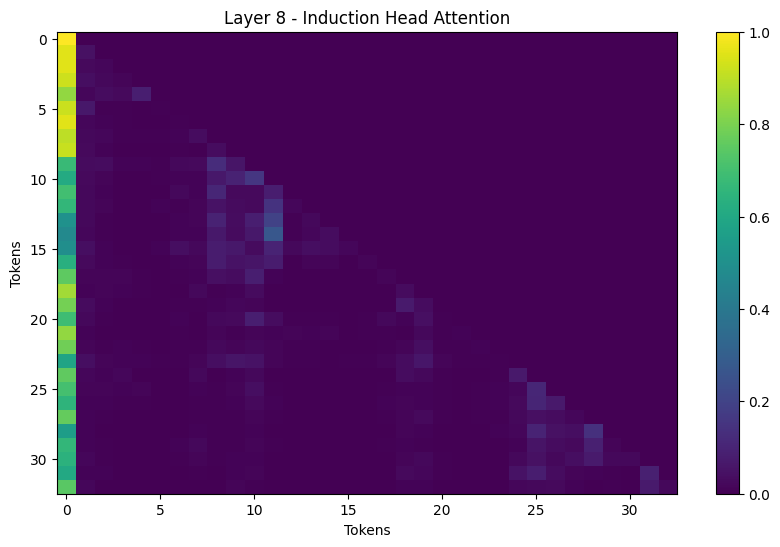

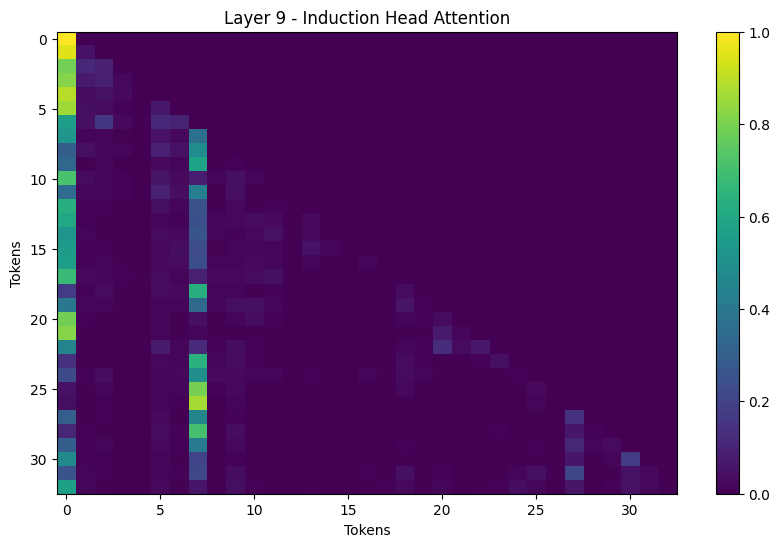

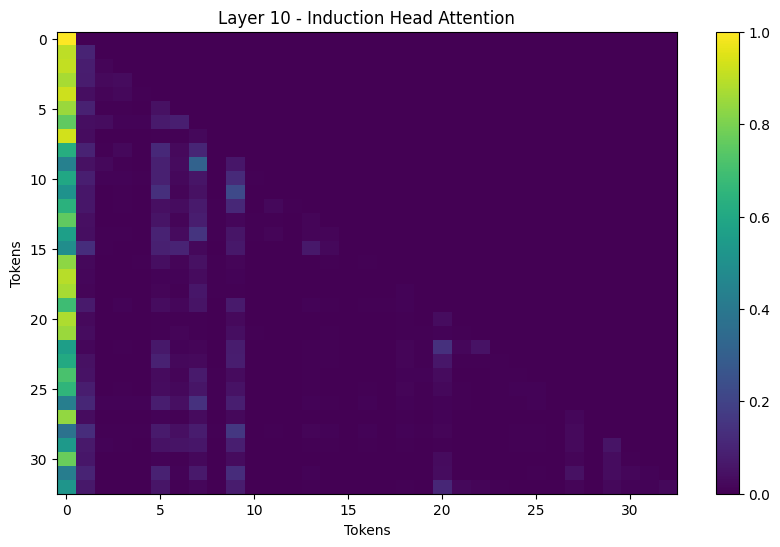

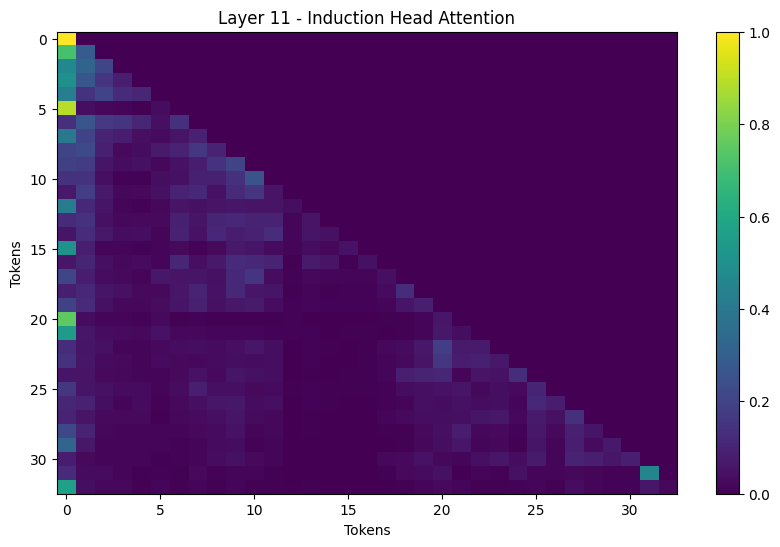

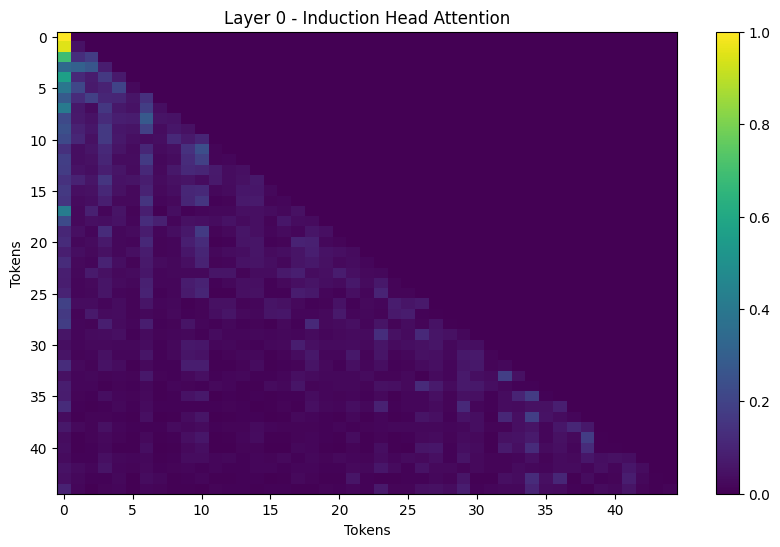

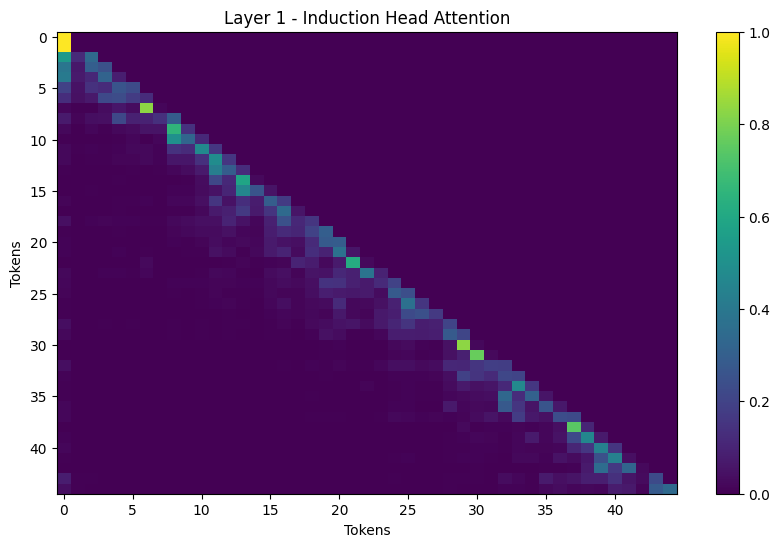

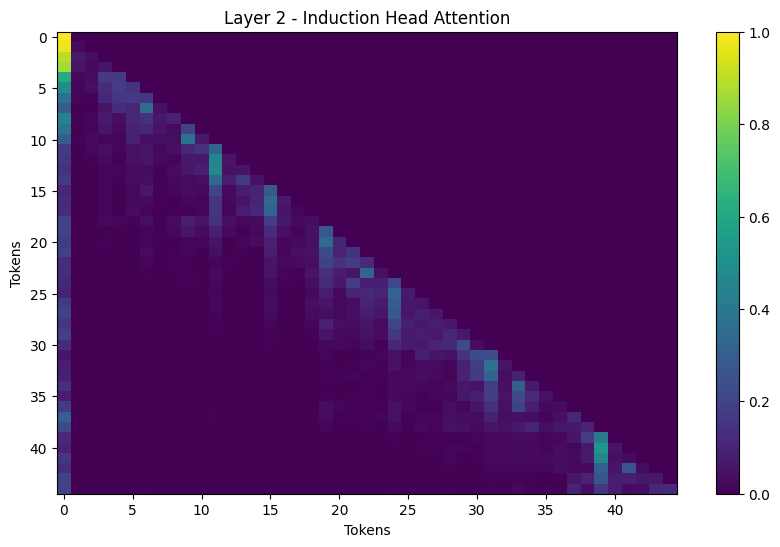

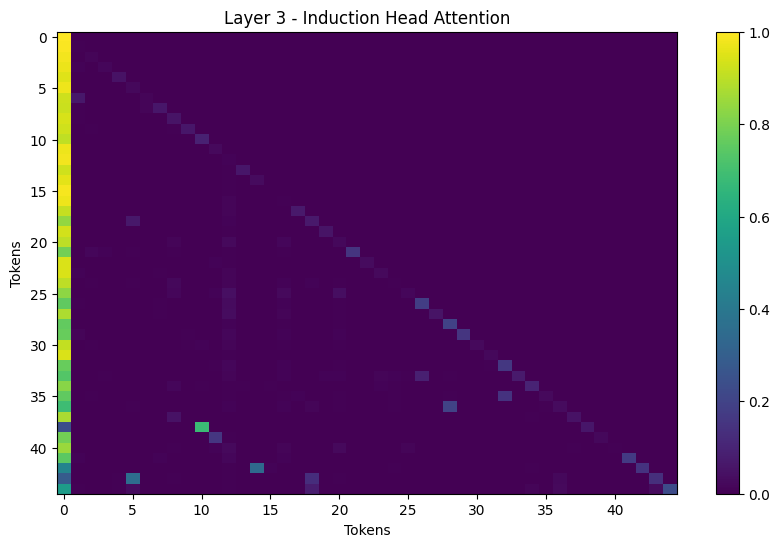

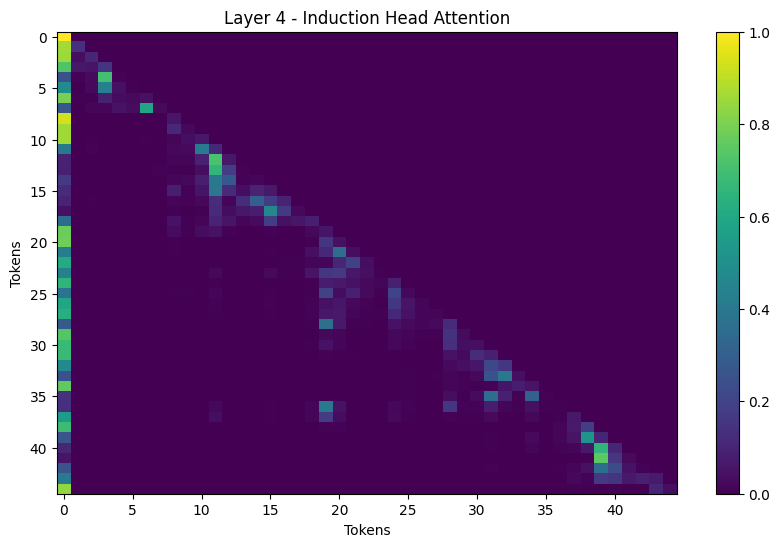

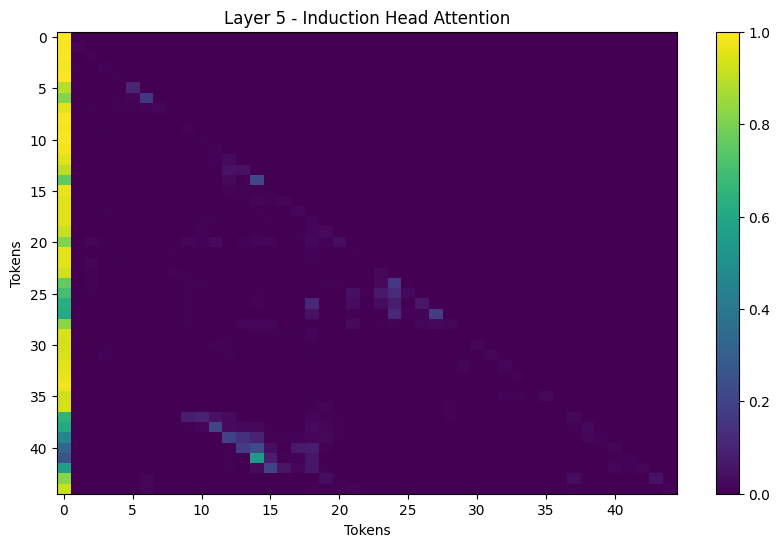

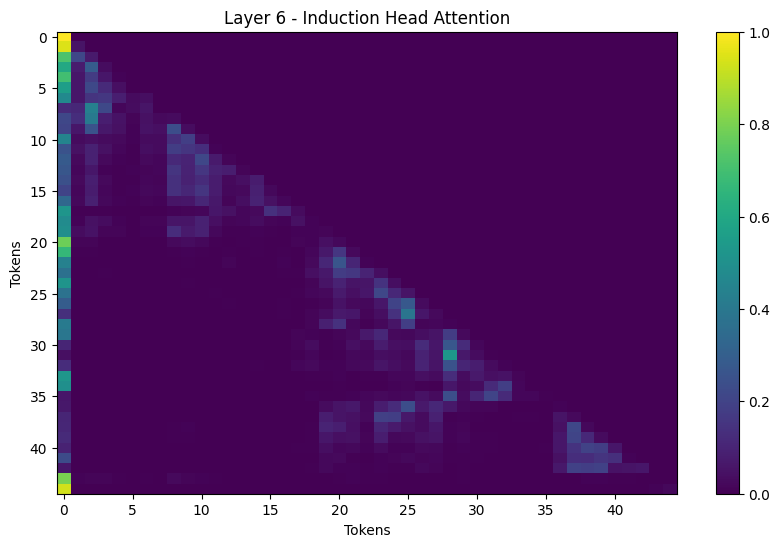

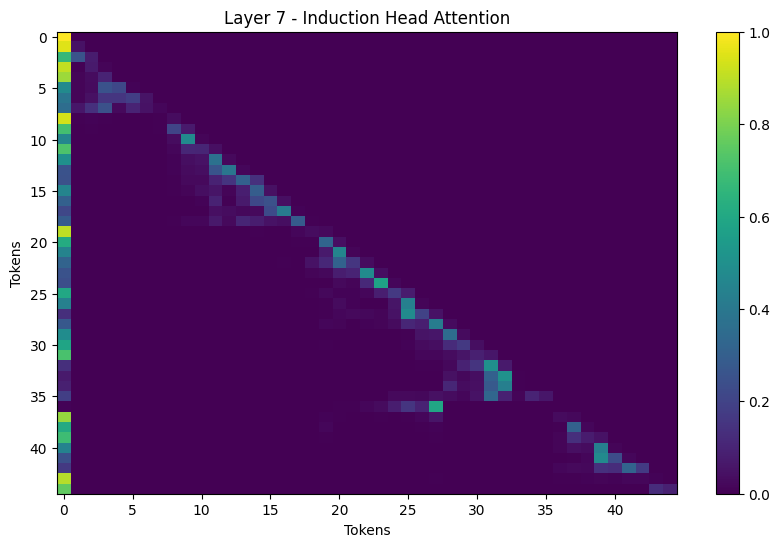

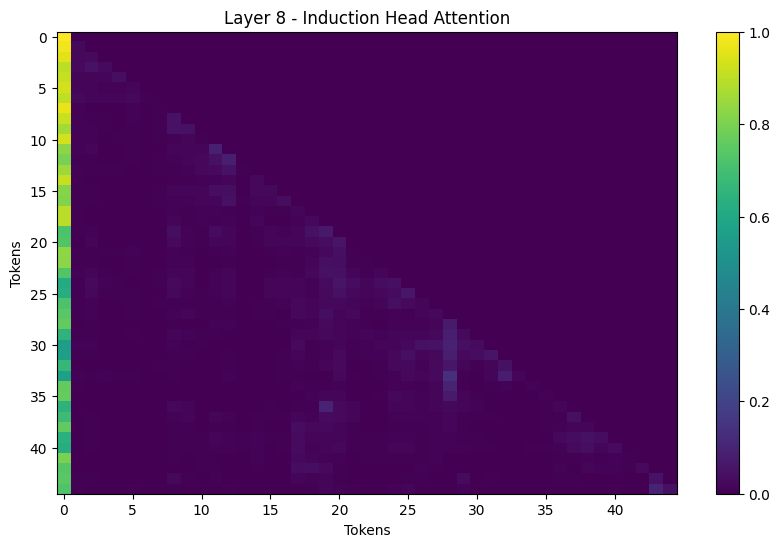

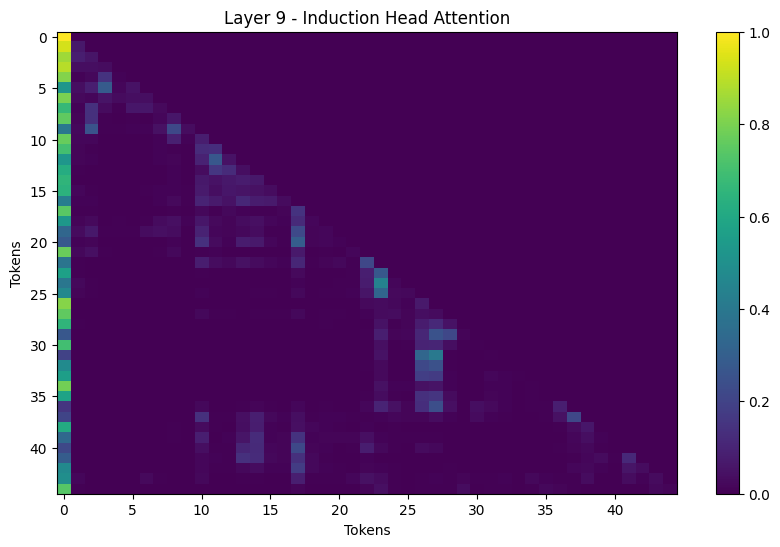

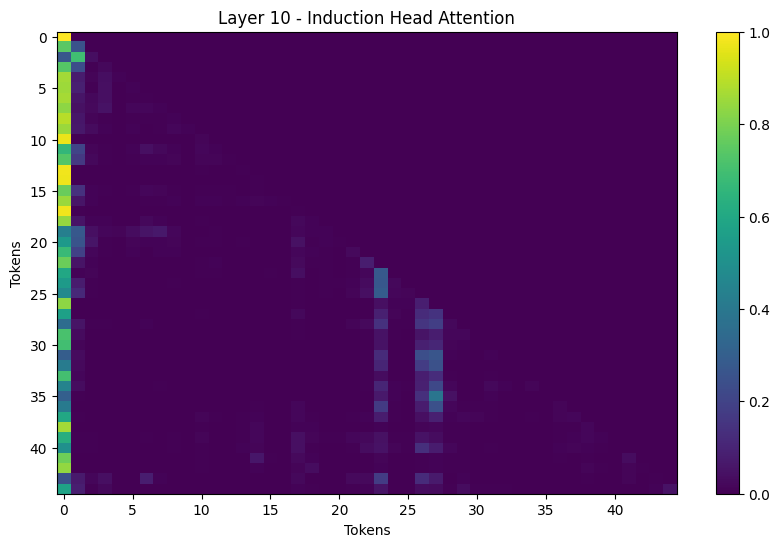

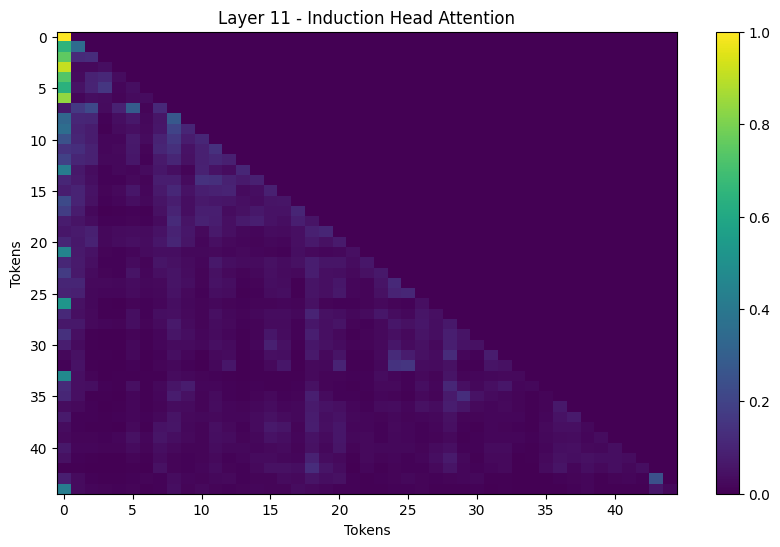

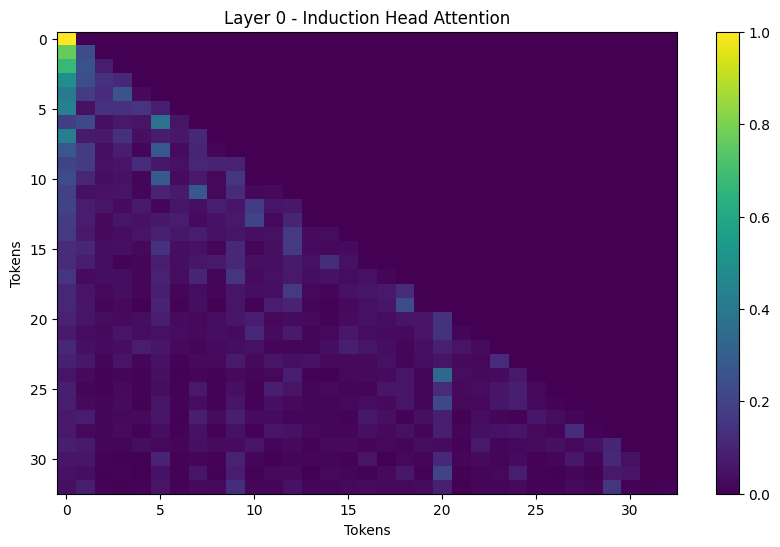

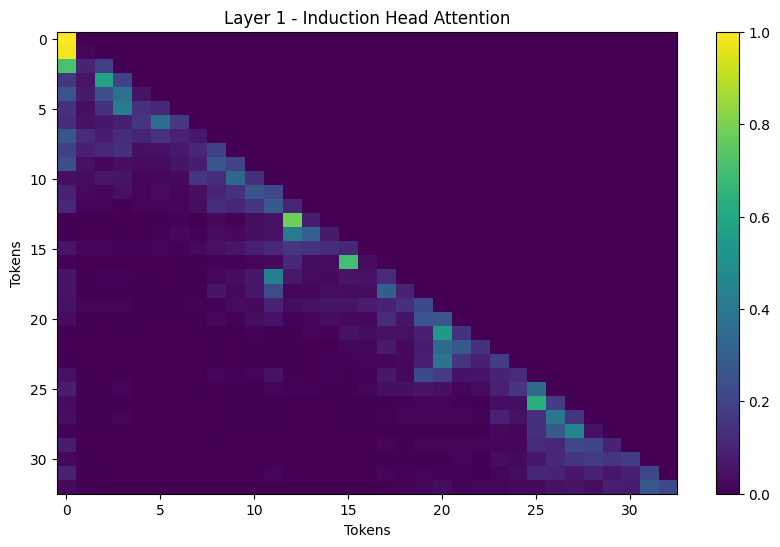

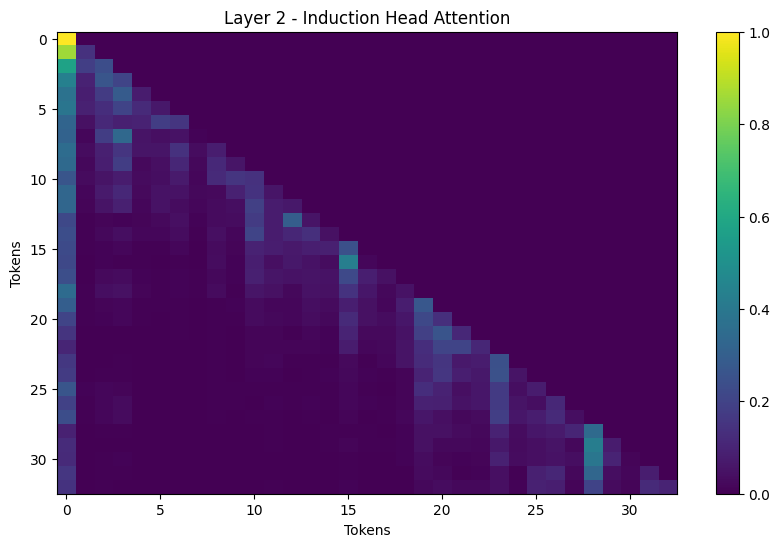

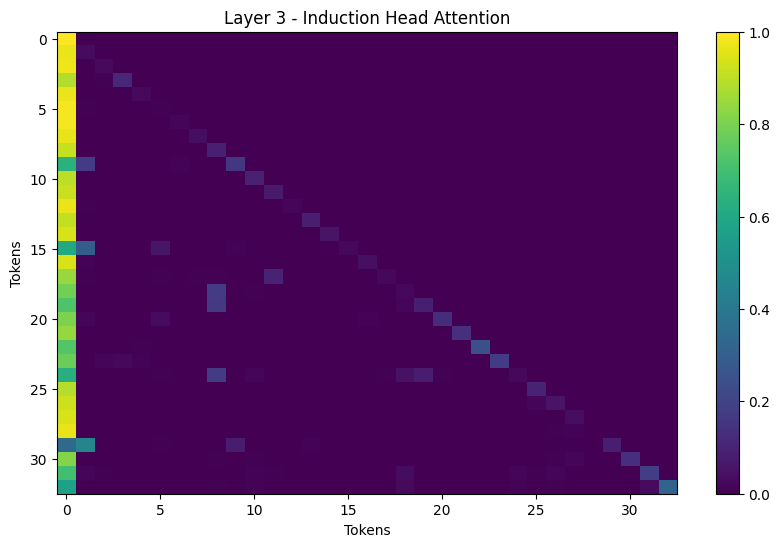

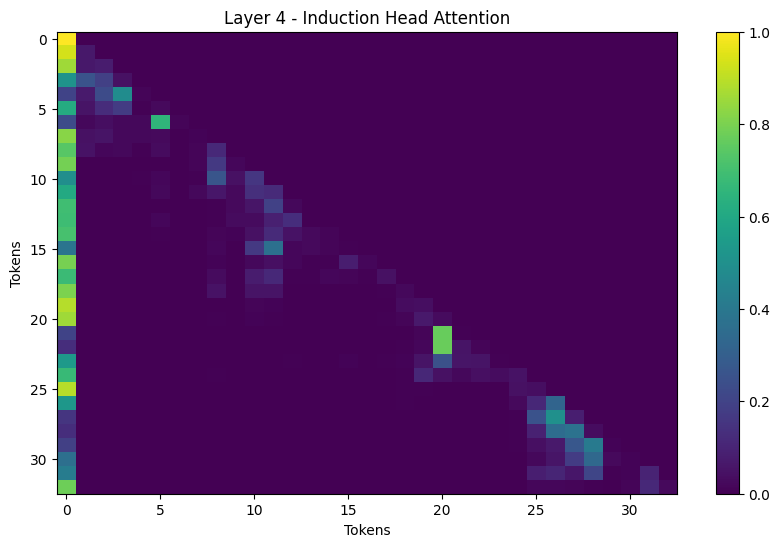

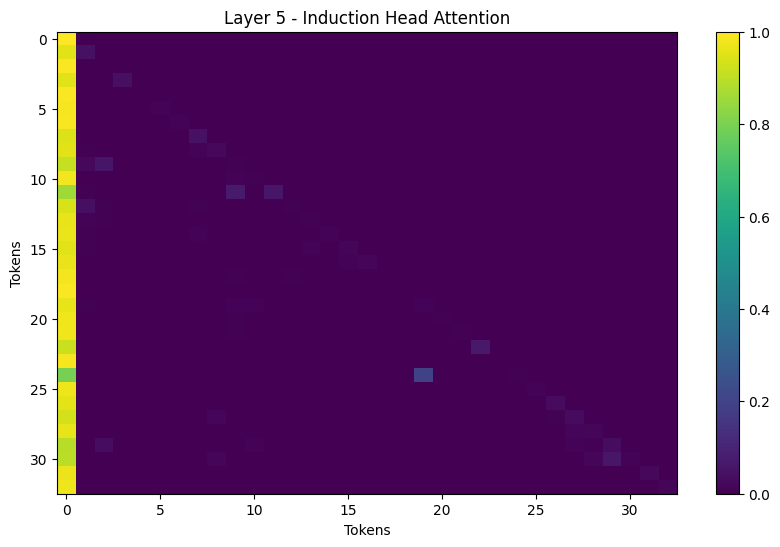

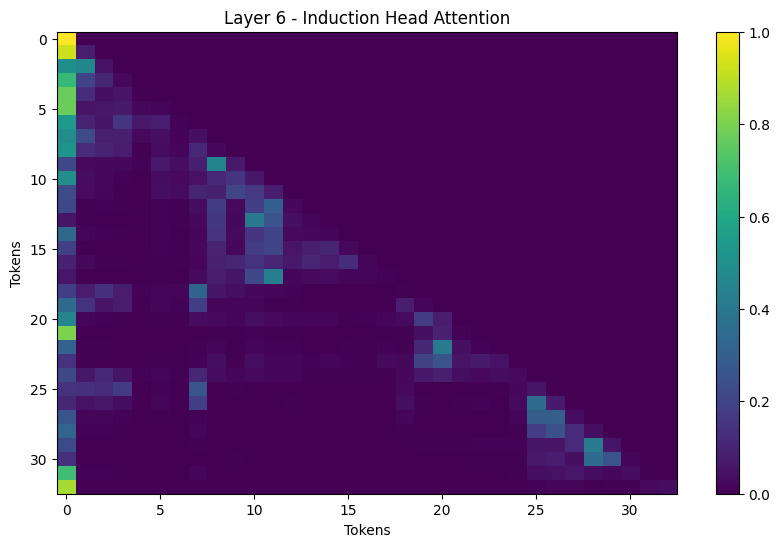

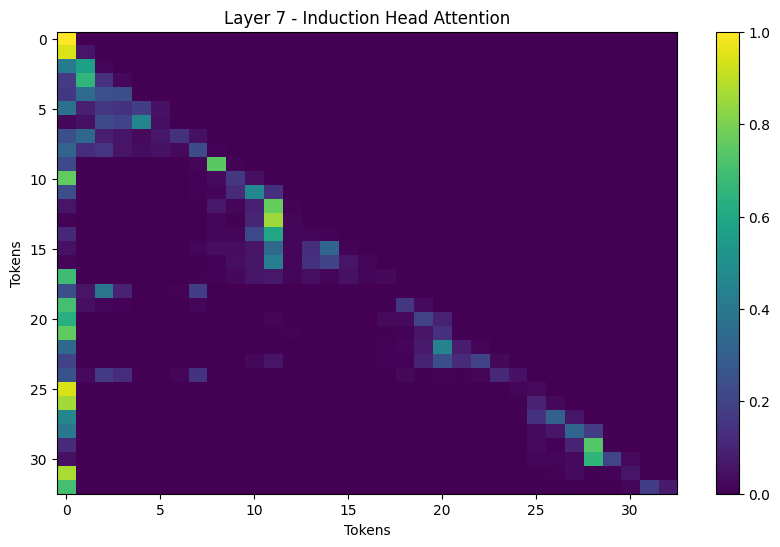

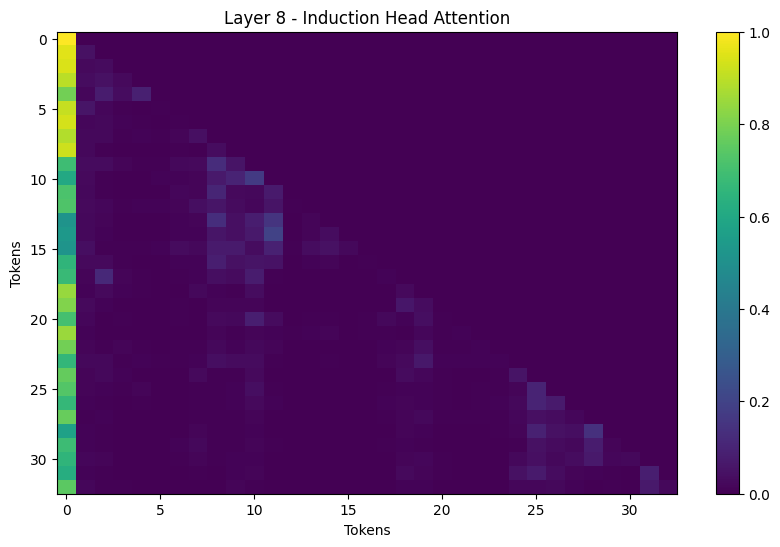

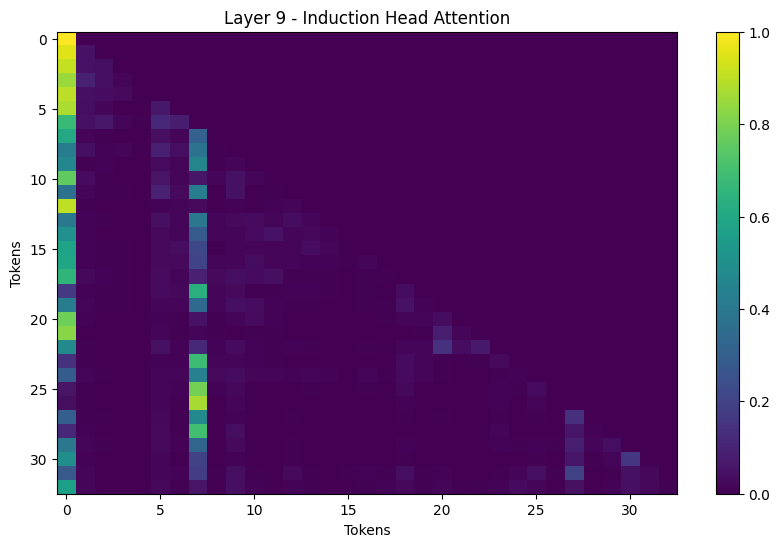

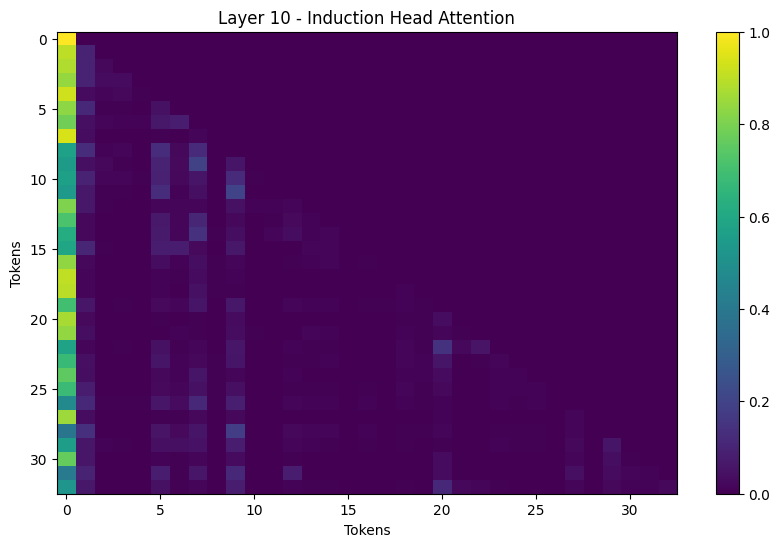

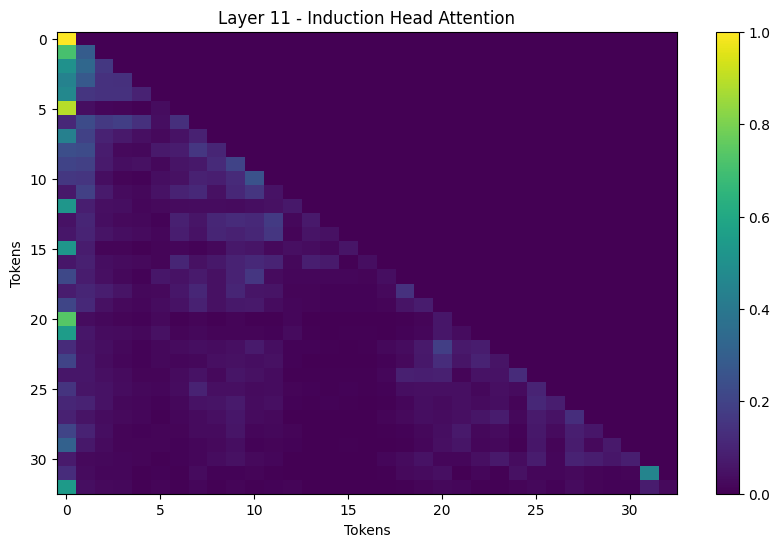

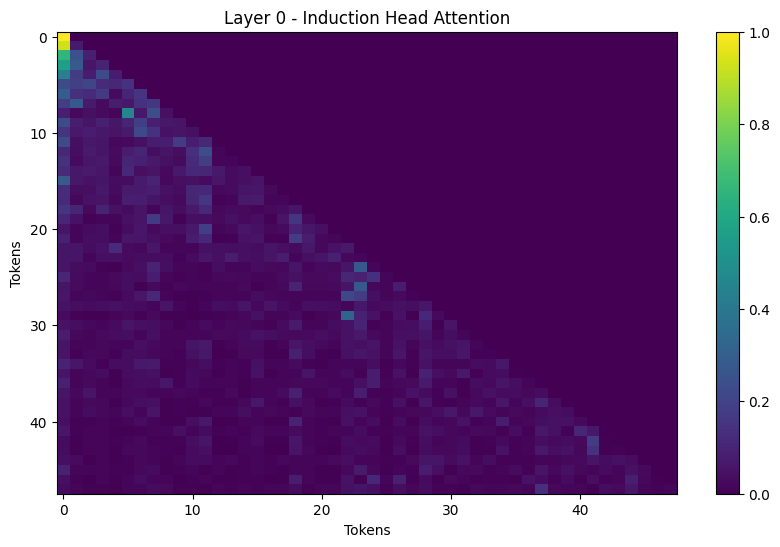

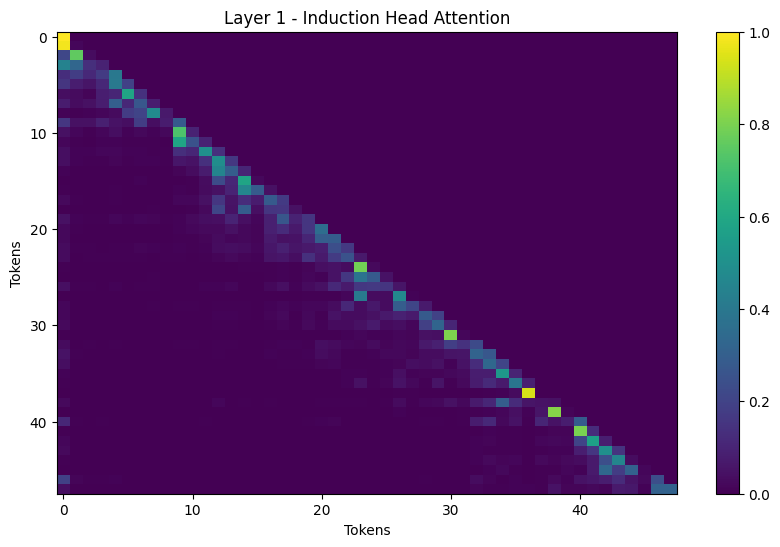

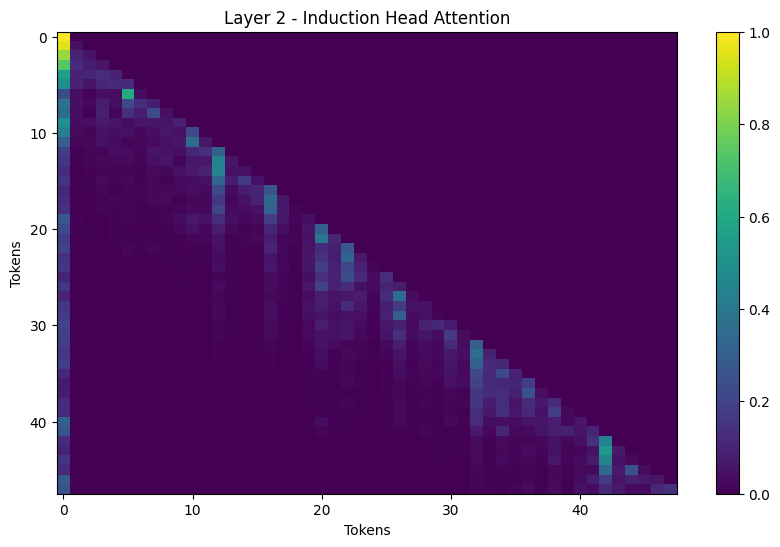

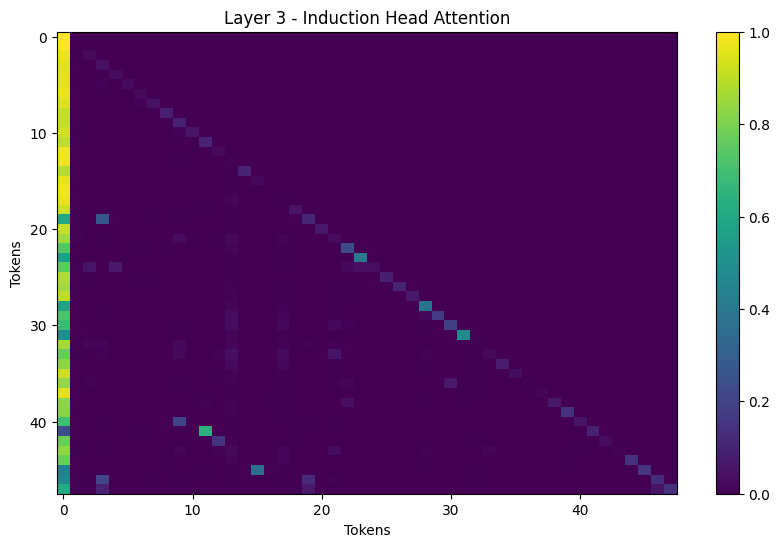

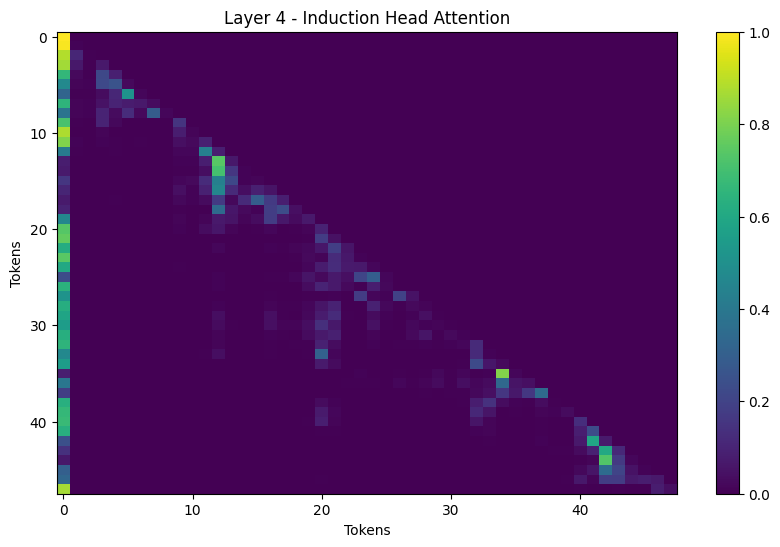

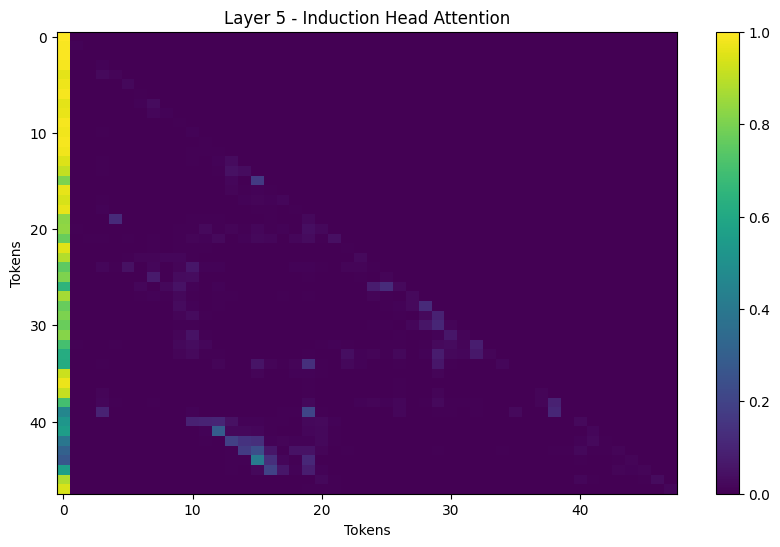

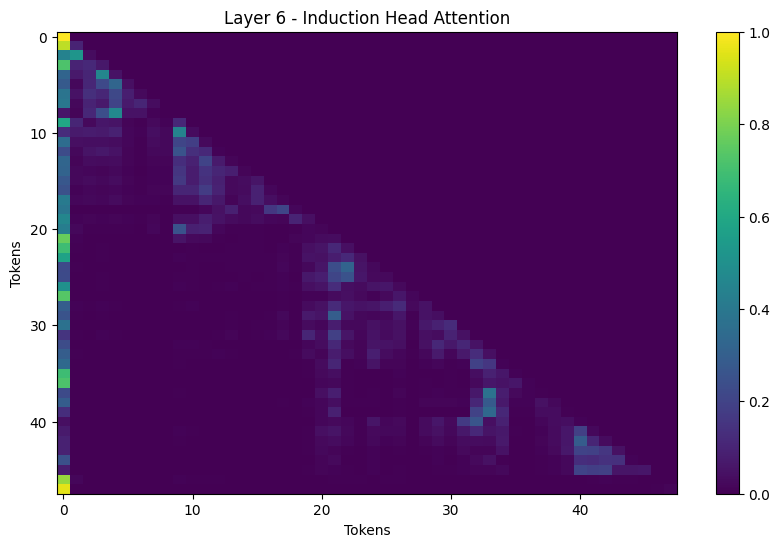

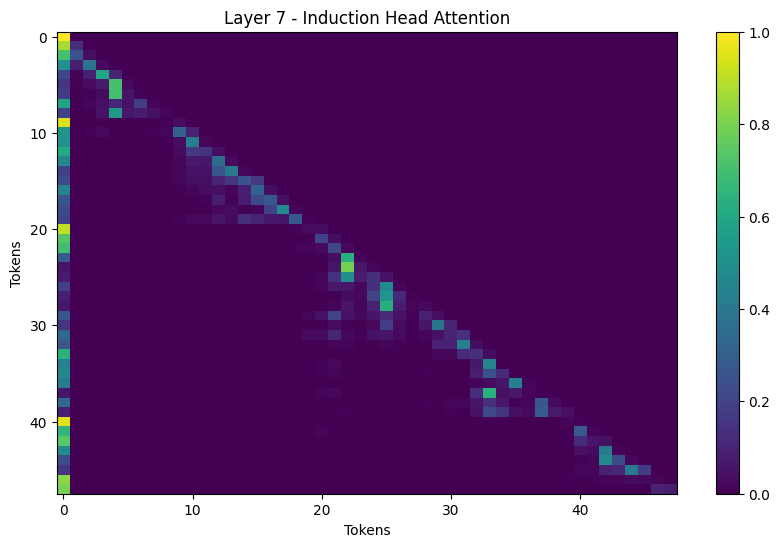

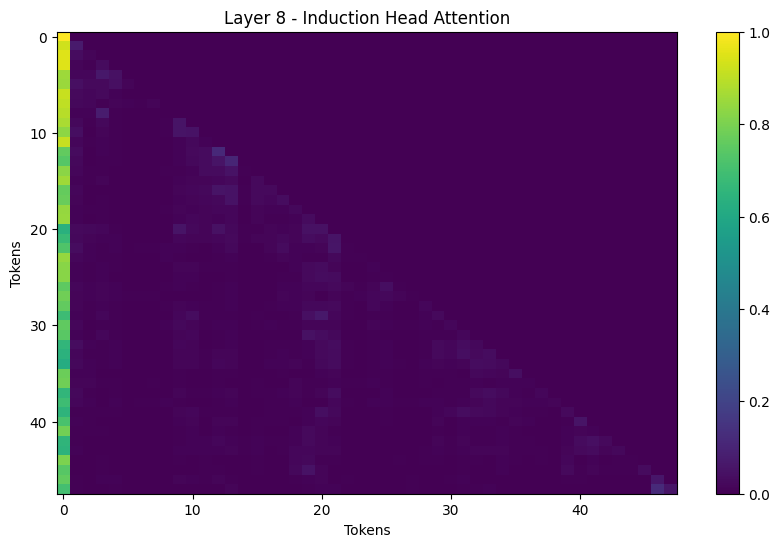

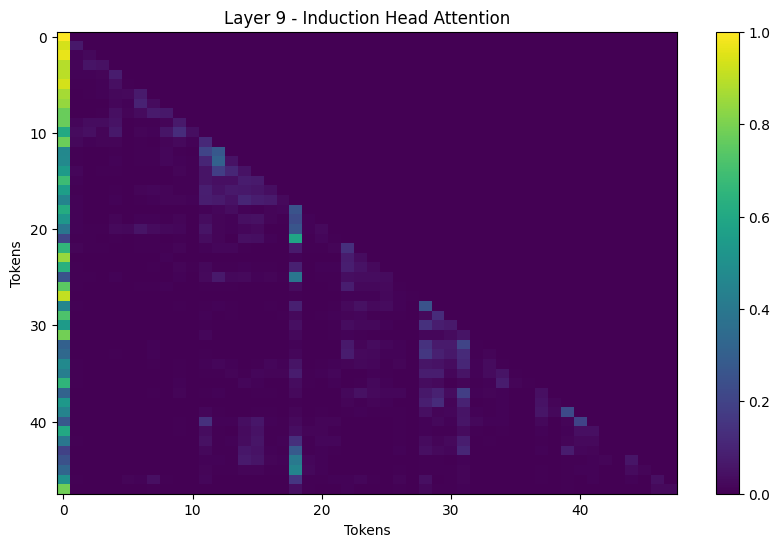

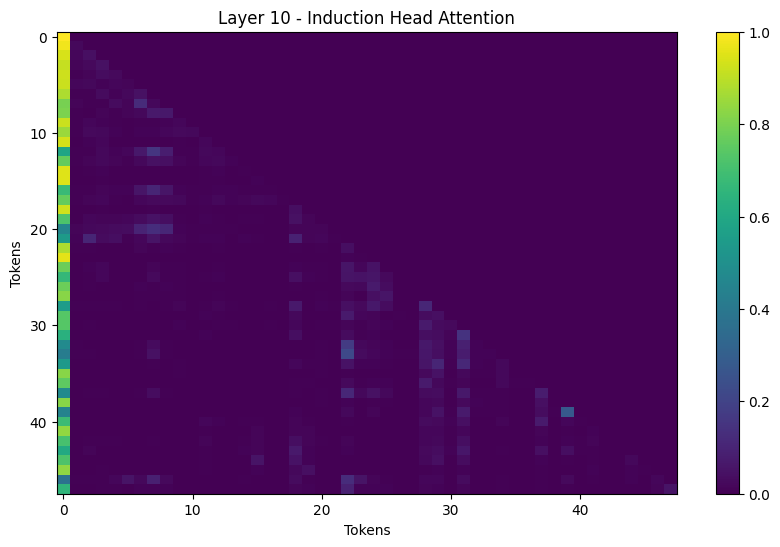

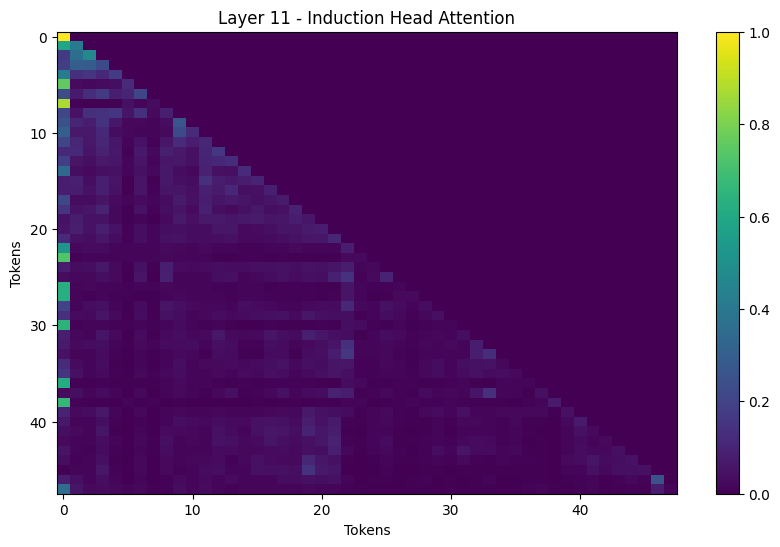

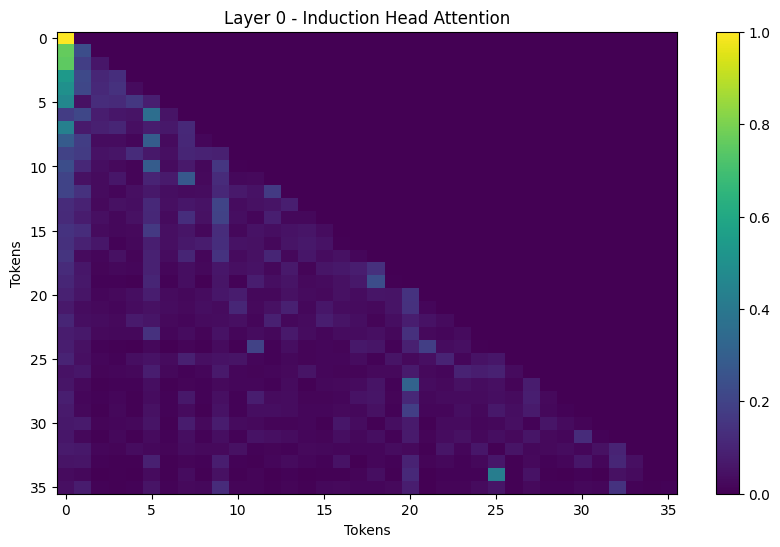

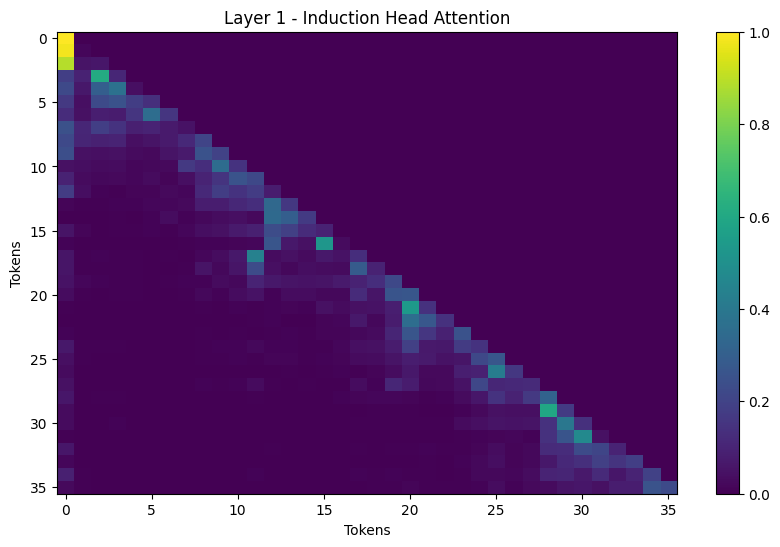

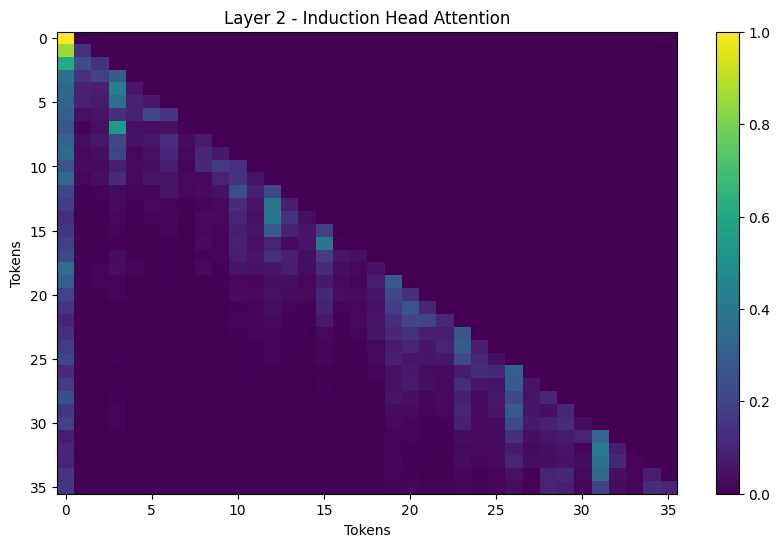

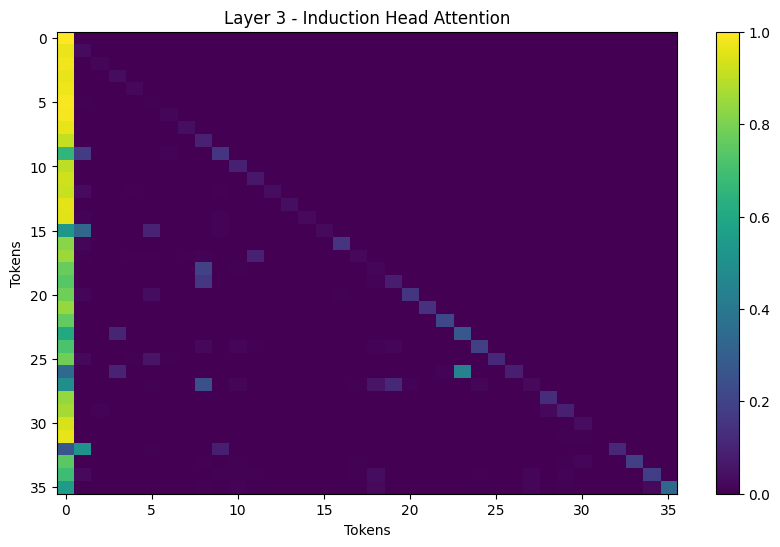

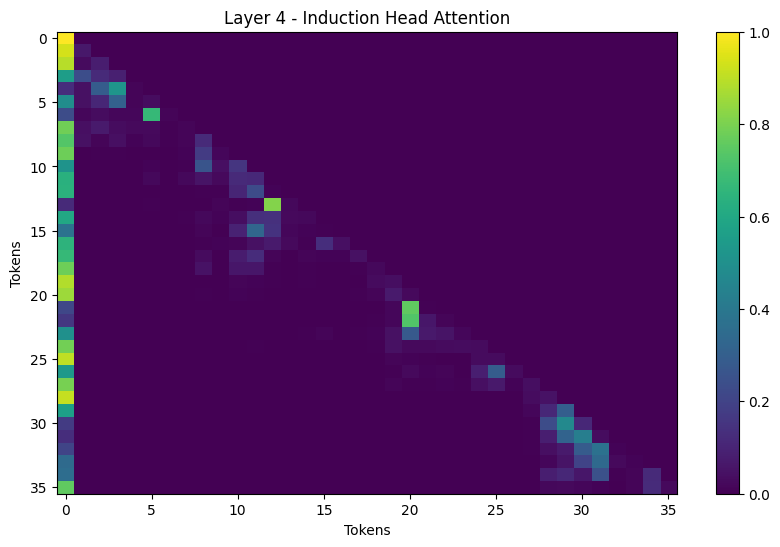

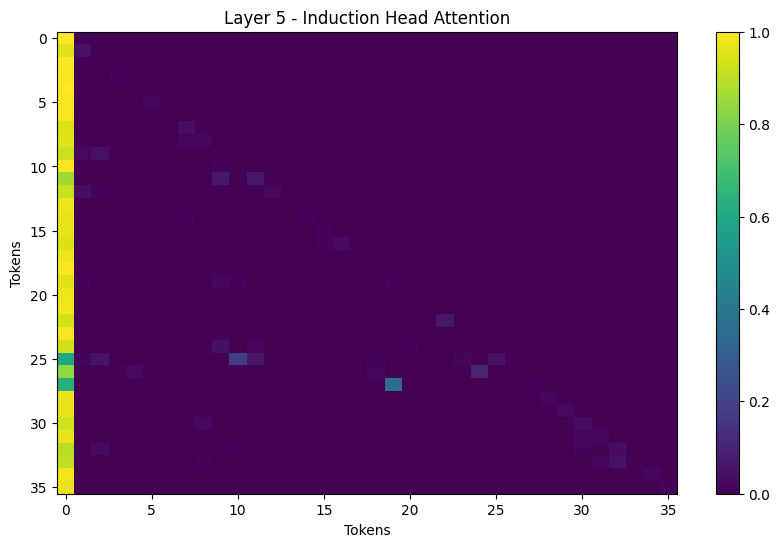

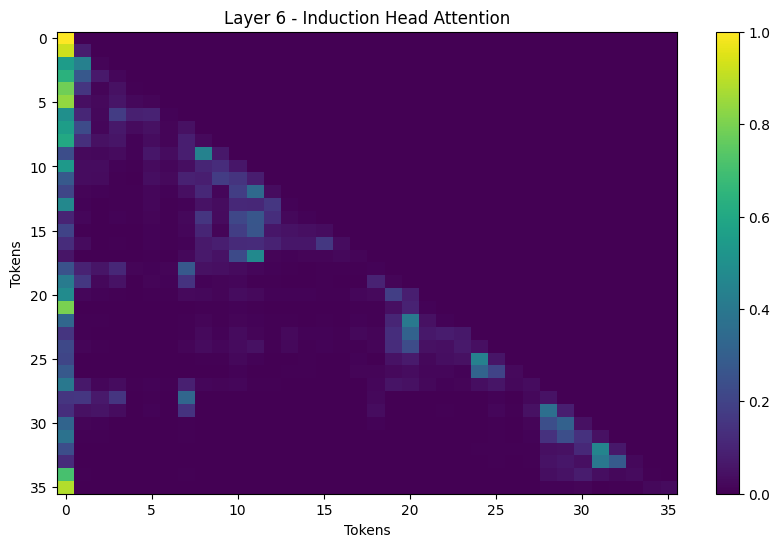

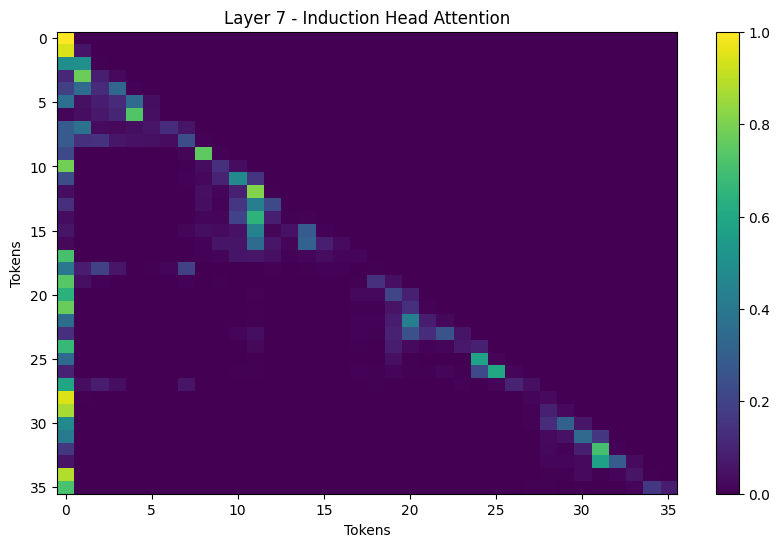

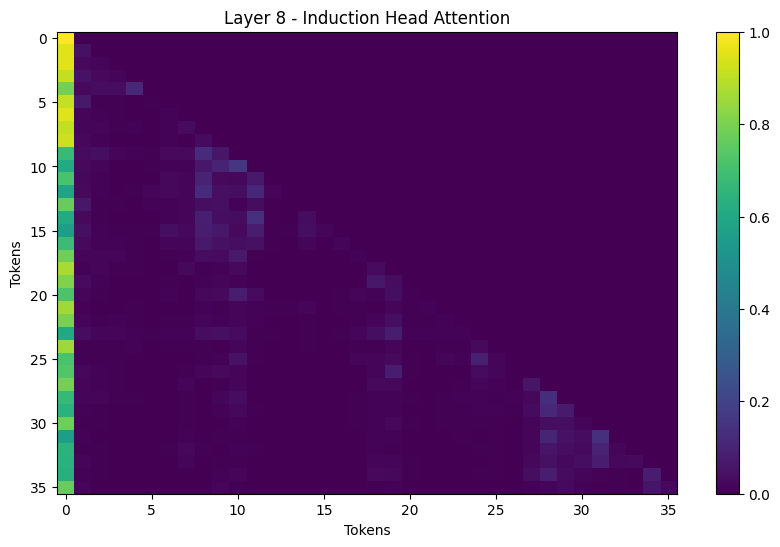

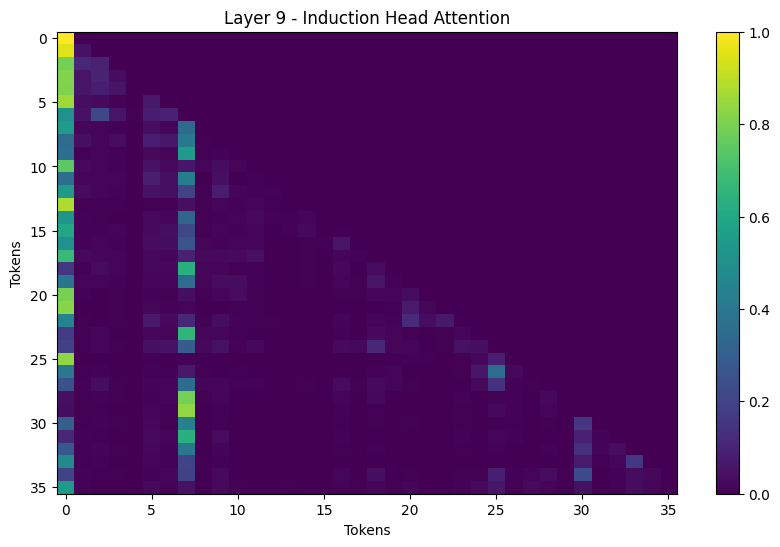

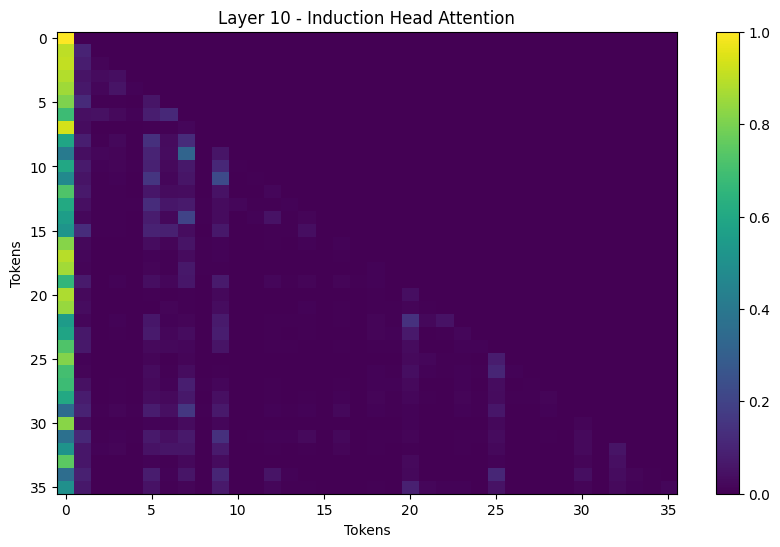

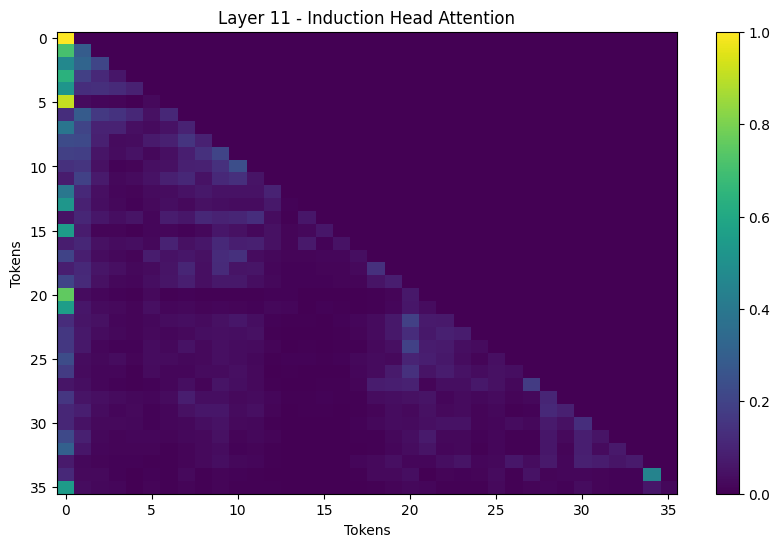

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

class SemanticICLFramework:
    def __init__(self, model_name, dataset_name):
        """
        Initialize the framework with a model and dataset.

        Parameters:
            model_name (str): The Hugging Face model name.
            dataset_name (str): The dataset name (from Hugging Face).
        """
        self.model_name = model_name
        self.dataset_name = dataset_name

        # Load model and tokenizer
        self.model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        # Load dataset
        self.dataset = load_dataset(dataset_name)

        # Preprocess dataset
        self.processed_data = self.preprocess_dataset()

    def preprocess_dataset(self):
        """
        Preprocess the dataset by tokenizing and extracting triplets.
        """
        processed = {}
        for split in self.dataset:
            processed[split] = [self.preprocess_example(example) for example in self.dataset[split]]
        return processed

    def preprocess_example(self, example):
        """
        Preprocess a single example by tokenizing text and extracting triplets.
        """
        text = self.extract_text(example)
        tokens = self.tokenizer(text, truncation=True, padding=True)
        triplets = self.extract_triplets(example)
        return {"text": text, "tokens": tokens, "triplets": triplets}

    def extract_text(self, example):
        """
        Extract text from the dataset example.
        """
        if self.dataset_name == "thunlp/few_rel":
            return " ".join(example.get("tokens", []))
        elif self.dataset_name == "Babelscape/rebel-dataset":
            return example.get("context", "")
        elif self.dataset_name == "thu-coai/kd_conv_with_kb":
            return example.get("content", "")
        else:
            raise ValueError("Unsupported dataset for text extraction.")

    def extract_triplets(self, example):
        """
        Extract triplets (head, relation, tail) from the example.
        """
        if self.dataset_name == "thunlp/few_rel":
            head = example.get("head", {}).get("text", "")
            tail = example.get("tail", {}).get("text", "")
            relation = example.get("relation", "")
            return [(head, relation, tail)]
        elif self.dataset_name == "Babelscape/rebel-dataset":
            return example.get("triplets", [])
        elif self.dataset_name == "thu-coai/kd_conv_with_kb":
            head = example.get("name", "")
            relation = example.get("attrname", "")
            tail = example.get("attrvalue", "")
            return [(head, relation, tail)]
        else:
            return []

    def analyze_attention_heads(self, input_ids, attention_mask):
        """
        Analyze attention heads for Query-Key and Output-Value circuits across various model architectures.
        """
        outputs = self.model(input_ids, attention_mask=attention_mask, output_attentions=True)
        attentions = outputs.attentions  # List of attention matrices from each layer
        return attentions

    def visualize_induction_head(self, attentions):
        """
        Visualize only the induction head's attention across layers.
        """
        induction_head_idx = 0  # Induction head is often the first head, but this may vary based on model
        for layer_idx, layer_attn in enumerate(attentions):
            # Select attention for the induction head (usually head 0 or similar)
            induction_head_attention = layer_attn[0, induction_head_idx, :, :].detach().cpu().numpy()

            # Plot attention dynamics for the induction head
            plt.figure(figsize=(10, 6))
            plt.imshow(induction_head_attention, cmap='viridis', aspect='auto')
            plt.colorbar()
            plt.title(f"Layer {layer_idx} - Induction Head Attention")
            plt.xlabel("Tokens")
            plt.ylabel("Tokens")
            plt.show()

# Example Usage
framework = SemanticICLFramework(model_name="gpt2", dataset_name="Babelscape/rebel-dataset")
processed_data = framework.processed_data["train"]

for example in processed_data[:5]:
    tokens = framework.tokenizer(example["text"], return_tensors="pt", truncation=True, padding=True)
    input_ids, attention_mask = tokens["input_ids"], tokens["attention_mask"]
    attentions = framework.analyze_attention_heads(input_ids, attention_mask)

    # Visualize attention for the induction head
    framework.visualize_induction_head(attentions)


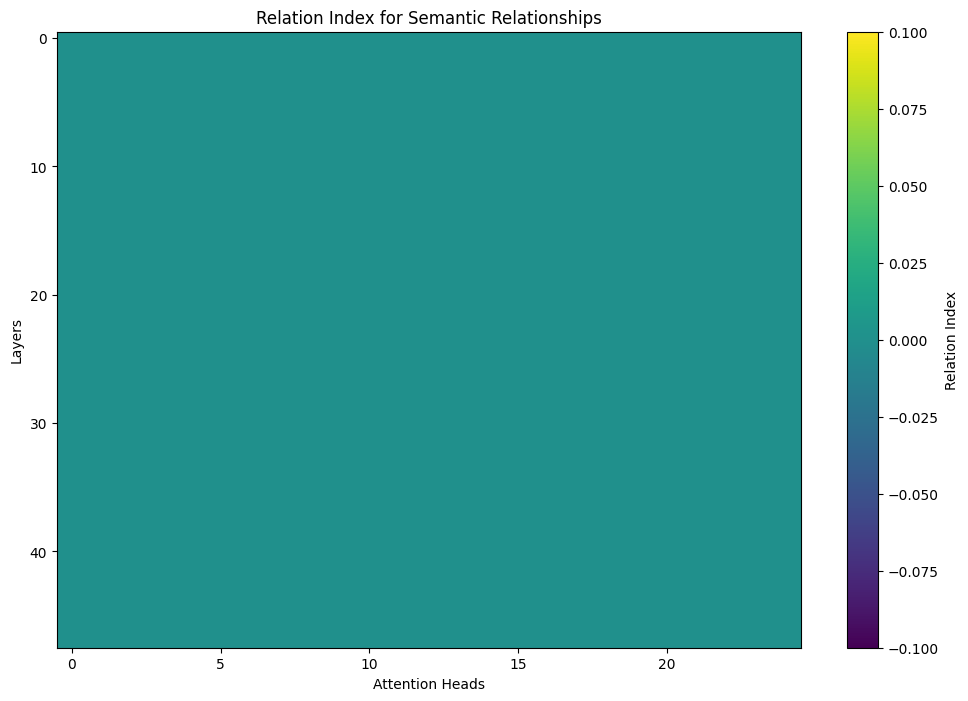

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer


class SemanticICLFramework:
    def __init__(self, model_name):
        """
        Initialize the framework with a model.

        Parameters:
            model_name (str): The Hugging Face model name.
        """
        self.model_name = model_name

        # Load model and tokenizer
        self.model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def analyze_attention_heads(self, input_ids, attention_mask):
        """
        Analyze attention heads for Query-Key and Output-Value circuits across various model architectures.
        """
        outputs = self.model(input_ids, attention_mask=attention_mask, output_attentions=True)
        attentions = outputs.attentions  # Attention matrices from each layer
        ov_circuit = self.model.state_dict()["transformer.h.0.attn.c_proj.weight"]  # Example for OV circuit
        return attentions, ov_circuit

    def compute_relation_index(self, attentions, ov_circuit, triplets, input_ids):
        """
        Compute the relation index for attention heads.
        """
        vocab_matrix = self.model.lm_head.weight  # Unembedding matrix
        num_layers = len(attentions)
        num_heads = attentions[0].size(1)
        relation_indices = np.zeros((num_layers, num_heads))

        # Get token-to-position mapping
        token_ids = input_ids[0].cpu().numpy()  # Use the first sequence in the batch (batch size = 1)
        token_to_pos = {token_id: idx for idx, token_id in enumerate(token_ids)}

        for layer_idx, layer_attn in enumerate(attentions):
            for head_idx in range(num_heads):
                for triplet in triplets:
                    head, _, tail = triplet
                    
                    # Get token indices for head and tail tokens
                    if head in token_to_pos and tail in token_to_pos:
                        head_idx_pos = token_to_pos[head]
                        tail_idx_pos = token_to_pos[tail]
                        print("*"*10)
                    else:
                        
                        continue  # Skip if head or tail not in sequence

                    # Attention weights
                    attention_weights = layer_attn[0, head_idx, :, :].detach().cpu().numpy()

                    # OV circuit influence
                    ov_influence = torch.matmul(ov_circuit[layer_idx, head_idx], vocab_matrix.T)
                    q_h = ov_influence[tail_idx_pos] - ov_influence.mean()
                    q_h = max(0, q_h.item())
                    relation_indices[layer_idx, head_idx] += q_h / ov_influence.sum().item()

        return relation_indices

    def visualize_relation_index(self, relation_indices):
        """
        Visualize the relation index as a heatmap.
        """
        plt.figure(figsize=(12, 8))
        plt.imshow(relation_indices, cmap="viridis", aspect="auto")
        plt.colorbar(label="Relation Index")
        plt.xlabel("Attention Heads")
        plt.ylabel("Layers")
        plt.title("Relation Index for Semantic Relationships")
        plt.show()


# Example Usage
framework = SemanticICLFramework(model_name="gpt2-xl")

examples = [
    {
        "text": "The pen is used for writing.",
        "triplets": [("pen", "Used-for", "writing")]
    },
    {
        "text": "A cat chases a mouse.",
        "triplets": [("cat", "Chases", "mouse")]
    },
    {
        "text": "The book contains valuable information.",
        "triplets": [("book", "Contains", "information")]
    },
    {
        "text": "She uses a laptop for programming.",
        "triplets": [("laptop", "Used-for", "programming")]
    },
    {
        "text": "The teacher explains the lesson.",
        "triplets": [("teacher", "Explains", "lesson")]
    }
]

all_relation_indices = []

for example in examples:
    tokens = framework.tokenizer(example["text"], return_tensors="pt", truncation=True, padding=True)
    input_ids, attention_mask = tokens["input_ids"], tokens["attention_mask"]
    attentions, ov_circuit = framework.analyze_attention_heads(input_ids, attention_mask)

    # Compute relation index for triplets in the example
    relation_indices = framework.compute_relation_index(attentions, ov_circuit, example["triplets"], input_ids)
    all_relation_indices.append(relation_indices)

# Aggregate results and visualize
mean_relation_indices = np.mean(all_relation_indices, axis=0)
framework.visualize_relation_index(mean_relation_indices)


In [1]:
# Implementation of framework
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
class SemanticICLFramework:
    def __init__(self, model_name):
        """Initialize framework with pretrained model."""
        self.model_name = model_name
        self.model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def analyze_attention_heads(self, input_ids, attention_mask):
        """Analyze attention patterns from model."""
        outputs = self.model(input_ids, attention_mask=attention_mask, output_attentions=True)
        attentions = outputs.attentions
        
        # Get OV circuits for all layers
        ov_circuits = []
        for i in range(len(attentions)):
            ov_circuits.append(self.model.state_dict()[f"transformer.h.{i}.attn.c_proj.weight"])
            
        return attentions, ov_circuits

    def compute_relation_index(self, attentions, ov_circuits, triplets, input_ids):
        vocab_matrix = self.model.get_output_embeddings().weight
        num_layers = len(attentions)
        num_heads = attentions[0].size(1) 
        relation_indices = np.zeros((num_layers, num_heads))
        
        tokens = [self.tokenizer.decode(t) for t in input_ids[0].cpu().numpy()]
        
        for layer_idx, layer_attn in enumerate(attentions):
            for head_idx in range(num_heads):
                head_scores = []
                
                for triplet in triplets:
                    head, _, tail = triplet
                    
                    head_positions = [i for i, t in enumerate(tokens) if head in t]
                    tail_positions = [i for i, t in enumerate(tokens) if tail in t]
                    
                    if not head_positions or not tail_positions:
                        continue
                        
                    head_idx_pos = head_positions[0] 
                    tail_idx_pos = tail_positions[0]

                    attention_weights = layer_attn[0, head_idx, :, :].detach().cpu().numpy()
                    
                    # Get OV influence and normalize by maximum value
                    ov_influence = torch.matmul(ov_circuits[layer_idx][head_idx], vocab_matrix.T)
                    ov_influence = ov_influence / ov_influence.max()
                    
                    # Calculate normalized score 
                    qk_score = attention_weights[tail_idx_pos, head_idx_pos]
                    ov_score = ov_influence[tail_idx_pos].item()
                    head_scores.append(qk_score * ov_score)

                # Take mean across triplets instead of sum
                if head_scores:
                    relation_indices[layer_idx, head_idx] = np.mean(head_scores)

        # Normalize final scores to [0,1] range
        relation_indices = (relation_indices - relation_indices.min()) / (relation_indices.max() - relation_indices.min())
        
        return relation_indices
# Usage example:
def visualize_relation_indices(framework, relation_indices):
    display(create_heatmap_html(relation_indices))


# First, import required libraries and create helper functions
from IPython.display import HTML
import json

def create_heatmap_html(relation_indices, title="Semantic Relationship Analysis"):
    # Convert numpy array to list for JSON serialization
    data = relation_indices.tolist()
    
    # Create the HTML string
    html = f"""
    <div style="width: 800px; font-family: Arial, sans-serif;">
        <div style="margin-bottom: 20px;">
            <h2 style="color: #333;">{title}</h2>
            <p style="color: #666;">Analyzing how attention heads encode semantic relationships</p>
        </div>
        
        <div style="display: flex; gap: 20px;">
            <!-- Heatmap -->
            <div style="flex: 2;">
                <div id="heatmap" style="position: relative;">
                    <!-- Heatmap will be rendered here -->
                </div>
                <div style="margin-top: 10px; text-align: center; color: #666;">
                    <div>Attention Heads</div>
                </div>
                <div style="position: absolute; left: -30px; top: 50%; transform: rotate(-90deg); color: #666;">
                    Layers
                </div>
            </div>
            
            <!-- Explanation Panel -->
            <div style="flex: 1; background: #f5f5f5; padding: 15px; border-radius: 5px;">
                <h3 style="margin-top: 0;">How to Read This Visualization</h3>
                <ul style="padding-left: 20px; color: #444;">
                    <li>Each cell represents an attention head</li>
                    <li>Darker blue indicates stronger relationship encoding</li>
                    <li>Rows represent layers in the transformer</li>
                    <li>Columns show attention heads within each layer</li>
                </ul>
                
                <h3>Key Patterns</h3>
                <ul style="padding-left: 20px; color: #444;">
                    <li>Middle layers often encode more semantic relationships</li>
                    <li>Some heads specialize in specific relationships</li>
                    <li>Earlier layers capture simpler relationships</li>
                    <li>Later layers show more complex patterns</li>
                </ul>
            </div>
        </div>
    </div>

    <script>
        // Create heatmap
        const data = {json.dumps(data)};
        const container = document.getElementById('heatmap');
        
        // Create grid of cells
        data.forEach((row, i) => {{
            const rowDiv = document.createElement('div');
            rowDiv.style.display = 'flex';
            rowDiv.style.height = '20px';
            
            row.forEach((value, j) => {{
                const cell = document.createElement('div');
                cell.style.width = '20px';
                cell.style.height = '100%';
                cell.style.backgroundColor = `rgb(${{Math.floor(255 * (1 - value))}}, ${{Math.floor(255 * (1 - value))}}, 255)`;
                cell.style.border = '1px solid white';
                cell.title = `Layer ${{i+1}}, Head ${{j+1}}: ${{value.toFixed(3)}}`;
                rowDiv.appendChild(cell);
            }});
            
            container.appendChild(rowDiv);
        }});
    </script>
    """
    return HTML(html)



# Initialize framework with GPT2-XL
framework = SemanticICLFramework("gpt2-xl")

# Example semantic relationship triplets
examples = [
    {
        "text": "The pen is used for writing.",
        "triplets": [("pen", "Used-for", "writing")]
    },
    {
        "text": "A cat chases a mouse.", 
        "triplets": [("cat", "Chases", "mouse")]
    }
]

relation_indices_list = []

# Process examples
for example in examples:
    # Tokenize input
    tokens = framework.tokenizer(example["text"], 
                                return_tensors="pt",
                                truncation=True, 
                                padding=True)
    
    # Get attention patterns
    attentions, ov_circuits = framework.analyze_attention_heads(
        tokens["input_ids"], 
        tokens["attention_mask"]
    )
    
    # Compute relation indices
    relation_indices = framework.compute_relation_index(
        attentions,
        ov_circuits, 
        example["triplets"],
        tokens["input_ids"]
    )
    
    relation_indices_list.append(relation_indices)

# Average results and visualize
mean_relation_indices = np.mean(relation_indices_list, axis=0)
# After computing relation indices:
visualize_relation_indices(framework, relation_indices)



/Users/lihongxuan/miniconda3/envs/icl/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [2]:
relation_indices

array([[0.64092653, 0.60625685, 0.70576715, ..., 0.66616124, 0.59891891,
        0.48505079],
       [0.62093341, 0.60643236, 0.62203616, ..., 0.62021946, 0.59534461,
        0.6212505 ],
       [0.60952575, 0.63026261, 0.55650688, ..., 0.62763487, 0.61051122,
        0.62928024],
       ...,
       [0.61720618, 0.61448549, 0.60232953, ..., 0.61434574, 0.61627496,
        0.62427996],
       [0.62113813, 0.61841735, 0.61841617, ..., 0.61241313, 0.67271855,
        0.62749801],
       [0.55940783, 0.61753116, 0.60015359, ..., 0.62366331, 0.61417105,
        0.60835682]])

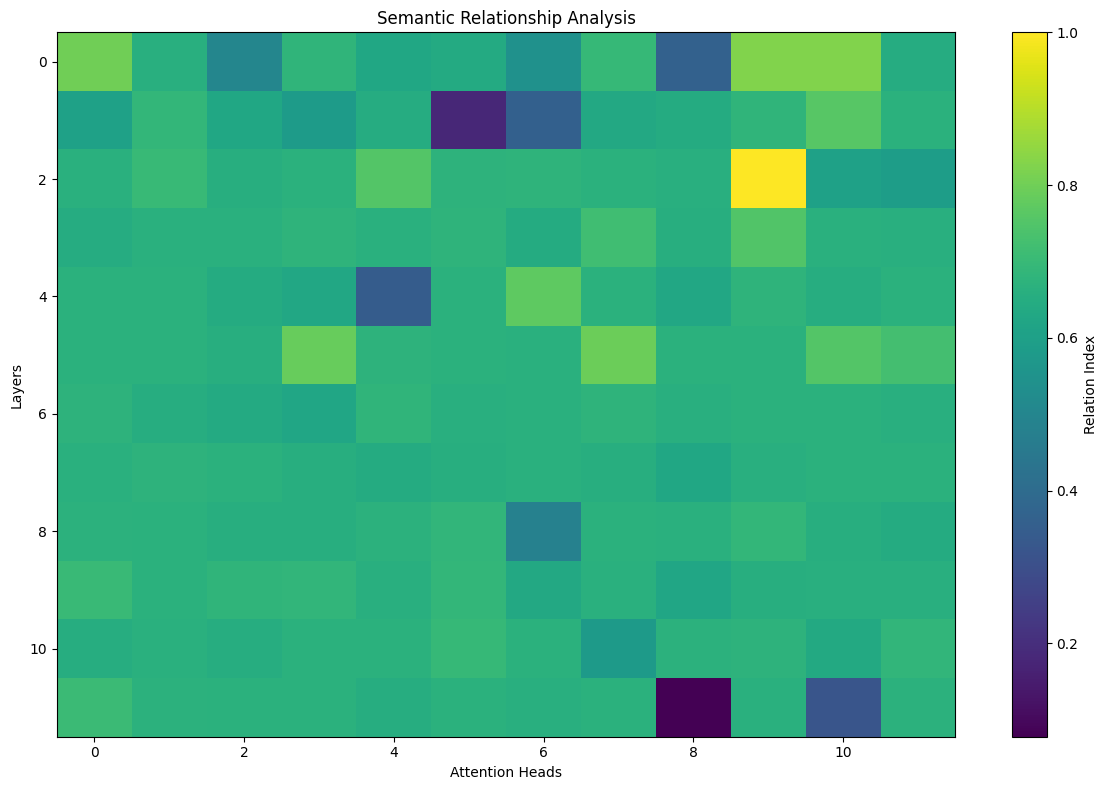

In [42]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer


# def compute_dynamic_tau(attention_weights, method='statistical', param=0):
#     if method == 'percentile':
#         return np.percentile(attention_weights, param)
#     elif method == 'statistical':
#         mean = np.mean(attention_weights)
#         std = np.std(attention_weights)
#         return mean + param * std
    

class SemanticICLFramework:
    def __init__(self, model_name):
        """Initialize framework with pretrained model."""
        self.model_name = model_name
        self.model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def get_layer_weight(self, layer_idx, weight_name):
        """Get layer weights in a flexible way."""
        return self.model.get_submodule(f'transformer.h.{layer_idx}.attn').get_parameter(weight_name)

    def analyze_attention_heads(self, input_ids, attention_mask):
        """Analyze attention patterns from model."""
        outputs = self.model(input_ids, attention_mask=attention_mask, output_attentions=True)
        attentions = outputs.attentions
        
        # Get OV circuits for all layers
        ov_circuits = []
        for i in range(len(attentions)):
            ov_circuits.append(self.get_layer_weight(i, 'c_proj.weight'))
            
        return attentions, ov_circuits

    def compute_relation_index(self, attentions, ov_circuits, triplets, input_ids, relation_type, tau=1e-4):
        vocab_matrix = self.model.get_output_embeddings().weight
        num_layers = len(attentions)
        num_heads = attentions[0].size(1) 
        relation_indices = np.zeros((num_layers, num_heads))
        
        tokens = [self.tokenizer.decode(t) for t in input_ids[0].cpu().numpy()]
        
        for layer_idx, layer_attn in enumerate(attentions):
            for head_idx in range(num_heads):
                head_scores = []
                
                for triplet in triplets:
                    head, rel, tail = triplet
                    
                    head_positions = [i for i, t in enumerate(tokens) if head in t]
                    tail_positions = [i for i, t in enumerate(tokens) if tail in t]
                    
                    if not head_positions or not tail_positions:
                        continue
                        
                    # Use average position for multi-token entities
                    head_idx_pos = sum(head_positions) / len(head_positions)
                    tail_idx_pos = sum(tail_positions) / len(tail_positions)

                    attention_weights = layer_attn[0, head_idx, :, :].detach().cpu().numpy()
                    # tau = compute_dynamic_tau(attention_weights)
                    
                    # Apply thresholding
                    if attention_weights[int(tail_idx_pos), int(head_idx_pos)] / np.max(attention_weights[int(tail_idx_pos), :]) <= tau:
                        continue
                    
                    # Get OV influence and normalize by maximum value
                    ov_influence = torch.matmul(ov_circuits[layer_idx][head_idx], vocab_matrix.T)
                    ov_influence = ov_influence / ov_influence.max()
                    
                    # Calculate normalized score 
                    qk_score = attention_weights[int(tail_idx_pos), int(head_idx_pos)]
                    ov_score = ov_influence[int(tail_idx_pos)].item()
                    
                    # Adjust scoring based on relation type
                    if relation_type == 'syntactic':
                        score = qk_score * ov_score
                    elif relation_type == 'semantic':
                        score = qk_score * ov_score * self.get_semantic_factor(rel)
                    else:
                        raise ValueError(f"Unknown relation type: {relation_type}")
                    
                    head_scores.append(score)

                # Take mean across triplets instead of sum
                if head_scores:
                    relation_indices[layer_idx, head_idx] = np.mean(head_scores)

        # Normalize final scores to [0,1] range

        relation_indices = (relation_indices - relation_indices.min()) / (relation_indices.max() - relation_indices.min())
        
        return relation_indices

    def get_semantic_factor(self, relation):
        """Return a factor based on the semantic relation type."""
        # This is a placeholder implementation. You should customize this based on your specific requirements.
        semantic_factors = {
            'Part-of': 1.2,
            'Compare': 1.0,
            'Used-for': 1.1,
            'Feature-of': 1.0,
            'Hyponym-of': 1.3,
            'Evaluate-for': 1.0,
            'Conjunction': 0.9
        }
        return semantic_factors.get(relation, 1.0)

    def visualize_relation_indices(self, relation_indices):
        plt.figure(figsize=(12, 8))
        plt.imshow(relation_indices, cmap='viridis', aspect='auto')
        plt.colorbar(label='Relation Index')
        plt.xlabel('Attention Heads')
        plt.ylabel('Layers')
        plt.title('Semantic Relationship Analysis')
        plt.tight_layout()
        plt.show()


framework = SemanticICLFramework("gpt2")

# Example semantic relationship triplets
examples = [
    {
        "text": "The pen is used for writing.",
        "triplets": [("pen", "Used-for", "writing")]
    },
    {
        "text": "A cat chases a mouse.", 
        "triplets": [("cat", "Chases", "mouse")]
    }
]

relation_indices_list = []

# Process examples
for example in examples:
    # Tokenize input
    tokens = framework.tokenizer(example["text"], 
                                return_tensors="pt",
                                truncation=True, 
                                padding=True)
    
    # Get attention patterns
    attentions, ov_circuits = framework.analyze_attention_heads(
        tokens["input_ids"], 
        tokens["attention_mask"]
    )
    
    # Compute relation indices
    relation_indices = framework.compute_relation_index(
        attentions,
        ov_circuits, 
        example["triplets"],
        tokens["input_ids"],
        relation_type="semantic"
    )
    
    relation_indices_list.append(relation_indices)

# Average results and visualize
mean_relation_indices = np.mean(relation_indices_list, axis=0)
framework.visualize_relation_indices(mean_relation_indices)


In [3]:
import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from IPython.display import display, HTML
import json

class SemanticICLFramework:
    def __init__(self, model_name):
        """Initialize framework with pretrained model."""
        self.model_name = model_name
        self.model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def get_layer_weight(self, layer_idx, weight_name):
        """Get layer weights in a flexible way."""
        return self.model.get_submodule(f'transformer.h.{layer_idx}.attn').get_parameter(weight_name)

    def analyze_attention_heads(self, input_ids, attention_mask):
        """Analyze attention patterns from model."""
        outputs = self.model(input_ids, attention_mask=attention_mask, output_attentions=True)
        attentions = outputs.attentions
        
        # Get OV circuits for all layers
        ov_circuits = []
        for i in range(len(attentions)):
            ov_circuits.append(self.get_layer_weight(i, 'c_proj.weight'))
            
        return attentions, ov_circuits

    def compute_relation_index(self, attentions, ov_circuits, triplets, input_ids, relation_type, tau=1e-4):
        vocab_matrix = self.model.get_output_embeddings().weight
        num_layers = len(attentions)
        num_heads = attentions[0].size(1) 
        relation_indices = np.zeros((num_layers, num_heads))
        
        tokens = [self.tokenizer.decode(t) for t in input_ids[0].cpu().numpy()]
        
        for layer_idx, layer_attn in enumerate(attentions):
            for head_idx in range(num_heads):
                head_scores = []
                
                for triplet in triplets:
                    head, rel, tail = triplet
                    
                    head_positions = [i for i, t in enumerate(tokens) if head in t]
                    tail_positions = [i for i, t in enumerate(tokens) if tail in t]
                    
                    if not head_positions or not tail_positions:
                        continue
                        
                    # Use average position for multi-token entities
                    head_idx_pos = sum(head_positions) / len(head_positions)
                    tail_idx_pos = sum(tail_positions) / len(tail_positions)

                    attention_weights = layer_attn[0, head_idx, :, :].detach().cpu().numpy()
                    
                    # Apply thresholding
                    if attention_weights[int(tail_idx_pos), int(head_idx_pos)] / np.max(attention_weights[int(tail_idx_pos), :]) <= tau:
                        continue
                    
                    # Get OV influence and normalize by maximum value
                    ov_influence = torch.matmul(ov_circuits[layer_idx][head_idx], vocab_matrix.T)
                    ov_influence = ov_influence / ov_influence.max()
                    
                    # Calculate normalized score 
                    qk_score = attention_weights[int(tail_idx_pos), int(head_idx_pos)]
                    ov_score = ov_influence[int(tail_idx_pos)].item()
                    
                    # Adjust scoring based on relation type
                    if relation_type == 'syntactic':
                        score = qk_score * ov_score
                    elif relation_type == 'semantic':
                        score = qk_score * ov_score * self.get_semantic_factor(rel)
                    else:
                        raise ValueError(f"Unknown relation type: {relation_type}")
                    
                    head_scores.append(score)

                # Take mean across triplets instead of sum
                if head_scores:
                    relation_indices[layer_idx, head_idx] = np.mean(head_scores)

        # Normalize final scores to [0,1] range
        relation_indices = (relation_indices - relation_indices.min()) / (relation_indices.max() - relation_indices.min())
        
        return relation_indices

    def get_semantic_factor(self, relation):
        """Return a factor based on the semantic relation type."""
        semantic_factors = {
            'Part-of': 1.2,
            'Compare': 1.0,
            'Used-for': 1.1,
            'Feature-of': 1.0,
            'Hyponym-of': 1.3,
            'Evaluate-for': 1.0,
            'Conjunction': 0.9
        }
        return semantic_factors.get(relation, 1.0)


    def visualize_relation_indices(framework, relation_indices):
        html, js = create_heatmap_html(relation_indices)
        display(html, js)

# def create_heatmap_html(relation_indices, title="Semantic Relationship Analysis"):
#     data = relation_indices.tolist()
    
#     html = f"""
#     <div id="heatmap-container" style="width: 800px; font-family: Arial, sans-serif;">
#         <div style="margin-bottom: 20px;">
#             <h2 style="color: #333;">{title}</h2>
#             <p style="color: #666;">Analyzing how attention heads encode semantic relationships</p>
#         </div>
        
#         <div style="display: flex; gap: 20px;">
#             <div style="flex: 2;">
#                 <div id="heatmap" style="position: relative;">
#                     <!-- Heatmap will be rendered here -->
#                 </div>
#                 <div style="margin-top: 10px; text-align: center; color: #666;">
#                     <div>Attention Heads</div>
#                 </div>
#                 <div style="position: absolute; left: -30px; top: 50%; transform: rotate(-90deg); color: #666;">
#                     Layers
#                 </div>
#             </div>
            
#             <div style="flex: 1; background: #f5f5f5; padding: 15px; border-radius: 5px;">
#                 <h3 style="margin-top: 0;">How to Read This Visualization</h3>
#                 <ul style="padding-left: 20px; color: #444;">
#                     <li>Each cell represents an attention head</li>
#                     <li>Darker blue indicates stronger relationship encoding</li>
#                     <li>Rows represent layers in the transformer</li>
#                     <li>Columns show attention heads within each layer</li>
#                 </ul>
                
#                 <h3>Key Patterns</h3>
#                 <ul style="padding-left: 20px; color: #444;">
#                     <li>Middle layers often encode more semantic relationships</li>
#                     <li>Some heads specialize in specific relationships</li>
#                     <li>Earlier layers capture simpler relationships</li>
#                     <li>Later layers show more complex patterns</li>
#                 </ul>
#             </div>
#         </div>
#     </div>
#     """

#     js = f"""
#     function createHeatmap() {{
#         const data = {json.dumps(data)};
#         const container = document.getElementById('heatmap');
#         if (!container) {{
#             console.error('Heatmap container not found');
#             return;
#         }}
        
#         data.forEach((row, i) => {{
#             const rowDiv = document.createElement('div');
#             rowDiv.style.display = 'flex';
#             rowDiv.style.height = '20px';
            
#             row.forEach((value, j) => {{
#                 const cell = document.createElement('div');
#                 cell.style.width = '20px';
#                 cell.style.height = '100%';
#                 cell.style.backgroundColor = `rgb(${{Math.floor(255 * (1 - value))}}, ${{Math.floor(255 * (1 - value))}}, 255)`;
#                 cell.style.border = '1px solid white';
#                 cell.title = `Layer ${{i+1}}, Head ${{j+1}}: ${{value.toFixed(3)}}`;
#                 rowDiv.appendChild(cell);
#             }});
            
#             container.appendChild(rowDiv);
#         }});
#     }}

#     createHeatmap();
#     """

#     return HTML(html), Javascript(js)
# # Usage example

from IPython.display import HTML, Javascript

def create_heatmap_html(relation_indices, title="Semantic Relationship Analysis"):
    data = relation_indices.tolist()
    
    html = f"""
    <div id="heatmap-container" style="width: 800px; font-family: Arial, sans-serif;">
        <div style="margin-bottom: 20px;">
            <h2 style="color: #333;">{title}</h2>
            <p style="color: #666;">Analyzing how attention heads encode semantic relationships</p>
        </div>
        
        <div style="display: flex; gap: 20px;">
            <!-- Heatmap -->
            <div style="flex: 2;">
                <div id="heatmap" style="position: relative;">
                    <!-- Heatmap will be rendered here -->
                </div>
                <div style="margin-top: 10px; text-align: center; color: #666;">
                    <div>Attention Heads</div>
                </div>
                <div style="position: absolute; left: -30px; top: 50%; transform: rotate(-90deg); color: #666;">
                    Layers
                </div>
            </div>
            
            <!-- Explanation Panel -->
            <div style="flex: 1; background: #f5f5f5; padding: 15px; border-radius: 5px;">
                <h3 style="margin-top: 0;">How to Read This Visualization</h3>
                <ul style="padding-left: 20px; color: #444;">
                    <li>Each cell represents an attention head</li>
                    <li>Darker blue indicates stronger relationship encoding</li>
                    <li>Rows represent layers in the transformer</li>
                    <li>Columns show attention heads within each layer</li>
                </ul>
                
                <h3>Key Patterns</h3>
                <ul style="padding-left: 20px; color: #444;">
                    <li>Middle layers often encode more semantic relationships</li>
                    <li>Some heads specialize in specific relationships</li>
                    <li>Earlier layers capture simpler relationships</li>
                    <li>Later layers show more complex patterns</li>
                </ul>
            </div>
        </div>
    </div>
    """

    js = f"""
    function createHeatmap() {{
        const data = {json.dumps(data)};
        const container = document.getElementById('heatmap');
        if (!container) {{
            console.error('Heatmap container not found');
            return;
        }}
        
        data.forEach((row, i) => {{
            const rowDiv = document.createElement('div');
            rowDiv.style.display = 'flex';
            rowDiv.style.height = '20px';
            
            row.forEach((value, j) => {{
                const cell = document.createElement('div');
                cell.style.width = '20px';
                cell.style.height = '100%';
                cell.style.backgroundColor = `rgb(${{Math.floor(255 * (1 - value))}}, ${{Math.floor(255 * (1 - value))}}, 255)`;
                cell.style.border = '1px solid white';
                cell.title = `Layer ${{i+1}}, Head ${{j+1}}: ${{value.toFixed(3)}}`;
                rowDiv.appendChild(cell);
            }});
            
            container.appendChild(rowDiv);
        }});
    }}

    // Run after a short delay to ensure DOM is ready
    setTimeout(createHeatmap, 100);
    """

    return HTML(html), Javascript(js)





framework = SemanticICLFramework("gpt2")

# Example semantic relationship triplets
examples = [
    {
        "text": "The pen is used for writing.",
        "triplets": [("pen", "Used-for", "writing")]
    },
    {
        "text": "A cat chases a mouse.", 
        "triplets": [("cat", "Chases", "mouse")]
    }
]

relation_indices_list = []

# Process examples
for example in examples:
    # Tokenize input
    tokens = framework.tokenizer(example["text"], 
                                return_tensors="pt",
                                truncation=True, 
                                padding=True)
    
    # Get attention patterns
    attentions, ov_circuits = framework.analyze_attention_heads(
        tokens["input_ids"], 
        tokens["attention_mask"]
    )
    
    # Compute relation indices
    relation_indices = framework.compute_relation_index(
        attentions,
        ov_circuits, 
        example["triplets"],
        tokens["input_ids"],
        relation_type="semantic"
    )
    
    relation_indices_list.append(relation_indices)

# Average results and visualize
mean_relation_indices = np.mean(relation_indices_list, axis=0)
framework.visualize_relation_indices(mean_relation_indices)

<IPython.core.display.Javascript object>

array([[0.80172365, 0.66103833, 0.49954643, 0.67964896, 0.62569192,
        0.64261641, 0.54477026, 0.69598902, 0.36379012, 0.825434  ,
        0.8242033 , 0.64806187],
       [0.60522973, 0.68868442, 0.62633339, 0.58363596, 0.65036235,
        0.17953629, 0.36130398, 0.63473135, 0.64389547, 0.68157775,
        0.76086435, 0.66504846],
       [0.66407537, 0.69904629, 0.65682328, 0.66510557, 0.7536997 ,
        0.67556306, 0.67685542, 0.66680165, 0.66058555, 1.        ,
        0.6042542 , 0.59251351],
       [0.64860481, 0.66339564, 0.66348611, 0.67807794, 0.66489598,
        0.67807253, 0.64582104, 0.71603877, 0.65597722, 0.74909125,
        0.66318477, 0.66082002],
       [0.66690383, 0.6671744 , 0.6464043 , 0.63065996, 0.34477291,
        0.66743975, 0.77013219, 0.66500121, 0.6322804 , 0.67594523,
        0.65311659, 0.66700416],
       [0.66718488, 0.66700416, 0.65663429, 0.78474195, 0.67325699,
        0.66527539, 0.66256396, 0.79123307, 0.66724771, 0.66827958,
        0.75491598,

In [ ]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import Dataset
import numpy as np
import random
from typing import List, Tuple, Dict

# 1. Initialization
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    
model = AutoModelForCausalLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cpu")
model.to(device)

# 2. Add Concept Tokens
task_name = "sentiment"
num_concept_tokens = 10
concept_tokens = [f"<{task_name}_token_{i}>" for i in range(1, num_concept_tokens + 1)]
special_tokens_dict = {'additional_special_tokens': concept_tokens}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
print(f"Added {num_added_toks} concept tokens.")
model.resize_token_embeddings(len(tokenizer))
concept_token_ids = tokenizer.convert_tokens_to_ids(concept_tokens)

with torch.no_grad():
    embeddings = model.get_input_embeddings().weight[concept_token_ids]
    print("Initial concept token embeddings (first 5 tokens):")
    print(embeddings[:5])

# 3. Data Preparation
def create_synthetic_dataset(num_samples: int) -> Dataset:
    data = {
        "input_text": [f"Sample input text {i}" for i in range(num_samples)],
        "labels": [random.choice(["positive", "negative"]) for i in range(num_samples)]
    }
    return Dataset.from_dict(data)

train_dataset = create_synthetic_dataset(1000)  # Use smaller sizes for CPU
test_dataset = create_synthetic_dataset(200)

def preprocess_function(examples, concept_token_ids: List[int]):
    concept_tokens_str = ' '.join([tokenizer.decode([tid]) for tid in concept_token_ids])
    inputs = [f"{concept_tokens_str} {text}" for text in examples["input_text"]]
    model_inputs = tokenizer(inputs, padding=True, truncation=True, return_tensors="pt")
    labels = tokenizer(examples["labels"], padding=True, truncation=True, return_tensors="pt")["input_ids"]
    model_inputs["labels"] = labels
    return model_inputs

train_dataset = train_dataset.map(lambda x: preprocess_function(x, concept_token_ids), batched=True)
test_dataset = test_dataset.map(lambda x: preprocess_function(x, concept_token_ids), batched=True)

# 4. Latent Concept Learning
for param in model.parameters():
    param.requires_grad = False

for token_id in concept_token_ids:
    model.get_input_embeddings().weight[token_id].requires_grad = True

def diversity_regularization(embeddings: torch.Tensor, lambda_reg: float = 0.1) -> torch.Tensor:
    normalized = nn.functional.normalize(embeddings, p=2, dim=1)
    similarity_matrix = torch.matmul(normalized, normalized.T)
    mask = torch.eye(similarity_matrix.size(0), device=embeddings.device)
    diversity_loss = (similarity_matrix * (1 - mask)).sum()
    return lambda_reg * diversity_loss

learning_rate = 1e-4
batch_size = 16
num_training_steps = 1000  # Reduced for CPU
lambda_reg = 0.1

optimizer = AdamW([model.get_input_embeddings().weight[token_id] for token_id in concept_token_ids], lr=learning_rate)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize loss contributions
token_loss_contributions = {token_id: 0.0 for token_id in concept_token_ids}

model.train()
for step in range(1, num_training_steps + 1):
    try:
        batch = next(iter(train_loader))
    except StopIteration:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        batch = next(iter(train_loader))
    
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    
    concept_embeddings = model.get_input_embeddings().weight[concept_token_ids]
    reg_loss = diversity_regularization(concept_embeddings, lambda_reg)
    
    total_loss = loss + reg_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    
    # Accumulate loss contributions
    for token_id in concept_token_ids:
        grad = model.get_input_embeddings().weight[token_id].grad
        token_loss_contributions[token_id] += grad.abs().sum().item()
    
    if step % 200 == 0:
        grad_norms = [model.get_input_embeddings().weight[token_id].grad.norm().item() for token_id in concept_token_ids]
        print(f"Step {step}: Loss={loss.item():.4f}, Reg_Loss={reg_loss.item():.4f}, Total_Loss={total_loss.item():.4f}")
        print(f"Gradient norms for concept tokens: {grad_norms}")
        print("Accumulated Loss Contributions:")
        for token_id, contrib in token_loss_contributions.items():
            token = tokenizer.decode([token_id])
            print(f"Token: {token}, Accumulated Contribution: {contrib:.4f}")
    
    optimizer.step()

# 5. Demonstration Selection
def compute_posterior_probabilities(model: AutoModelForCausalLM, tokenizer, demonstration: Tuple[str, str], concept_token_ids: List[int], tasks: List[str], device: torch.device) -> Dict[str, float]:
    posterior = {}
    log_probs = {}
    
    X_d, Y_d = demonstration
    for task in tasks:
        # Assume each task has its own set of concept tokens
        # For simplicity, we use the same concept tokens
        concept_tokens_str = ' '.join([tokenizer.decode([tid]) for tid in concept_token_ids])
        input_text = f"{concept_tokens_str} {X_d}"
        input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
        labels = tokenizer.encode(Y_d, return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, labels=labels)
            # Compute log probability P(Y | X, theta)
            log_prob = -outputs.loss.item()  # Negative loss is the log probability
            log_probs[task] = log_prob
    
    # Convert log probabilities to probabilities
    max_log_prob = max(log_probs.values())
    exp_probs = {task: np.exp(log_prob - max_log_prob) for task, log_prob in log_probs.items()}
    sum_exp = sum(exp_probs.values())
    posterior = {task: prob / sum_exp for task, prob in exp_probs.items()}
    
    return posterior

def select_top_k_demos(model: AutoModelForCausalLM, tokenizer, dataset: Dataset, concept_token_ids: List[int], tasks: List[str], k: int, device: torch.device) -> List[Dict]:
    """
    Selects top-k demonstrations based on posterior probabilities.
    """
    demonstration_scores = []
    
    for example in dataset:
        X_d = example["input_text"]
        Y_d = example["labels"]
        posterior = compute_posterior_probabilities(model, tokenizer, (X_d, Y_d), concept_token_ids, tasks, device)
        # For ranking, we can use the posterior probability of the most probable task
        top_task = max(posterior, key=posterior.get)
        top_prob = posterior[top_task]
        demonstration_scores.append({
            "example": example,
            "top_task": top_task,
            "score": top_prob
        })
    
    # Sort demonstrations by score in descending order
    sorted_demos = sorted(demonstration_scores, key=lambda x: x["score"], reverse=True)
    
    # Select top-k
    top_k_demos = sorted_demos[:k]
    return top_k_demos

# Example tasks
tasks = ["sentiment", "topic", "emotion"]  # Extend as needed

# Select top-k demonstrations
k = 4
top_k_demos = select_top_k_demos(model, tokenizer, train_dataset, concept_token_ids, tasks, k, device)

print(f"\nTop-{k} Demonstrations:")
for idx, demo in enumerate(top_k_demos):
    print(f"{idx+1}. Task: {demo['top_task']}, Score: {demo['score']:.4f}")
    print(f"   Input: {demo['example']['input_text']}")
    print(f"   Label: {demo['example']['labels']}")


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Added 10 concept tokens.
Initial concept token embeddings (first 5 tokens):
tensor([[-0.0025, -0.0585,  0.1174,  ...,  0.0236,  0.0039,  0.0344],
        [-0.0025, -0.0585,  0.1174,  ...,  0.0236,  0.0039,  0.0344],
        [-0.0025, -0.0585,  0.1174,  ...,  0.0236,  0.0039,  0.0344],
        [-0.0025, -0.0585,  0.1174,  ...,  0.0236,  0.0039,  0.0344],
        [-0.0025, -0.0585,  0.1174,  ...,  0.0236,  0.0039,  0.0344]])


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

AttributeError: 'list' object has no attribute 'to'

In [8]:
average_relation_indices

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}

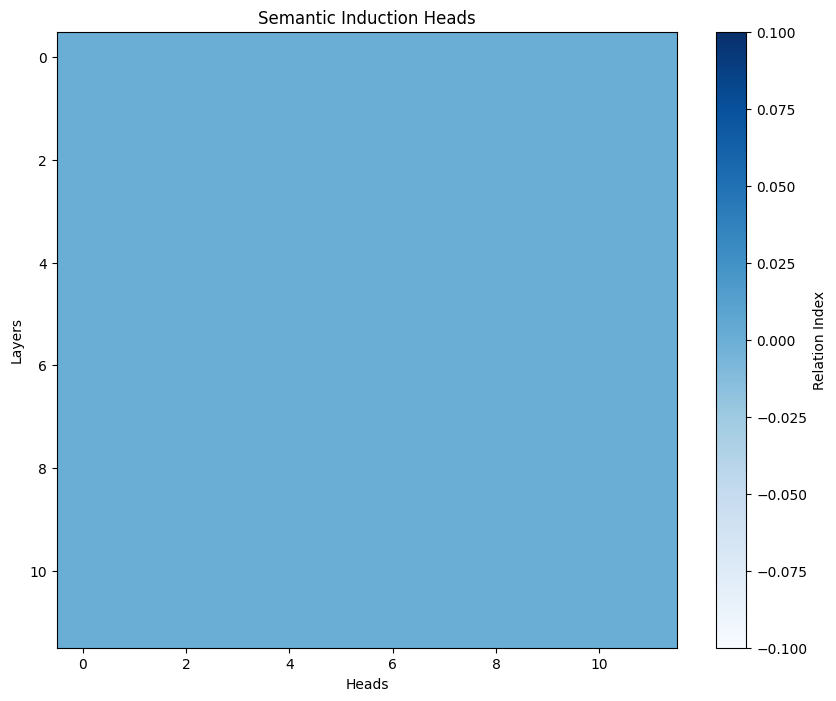

In [ ]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

class SemanticICLFramework:
    def __init__(self, model_name, dataset_name):
        self.model_name = model_name
        self.dataset_name = dataset_name
        
        self.model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        
        self.dataset = load_dataset(dataset_name)
        self.processed_data = self.preprocess_dataset()

    def preprocess_dataset(self):
        processed = {}
        for split in self.dataset:
            processed[split] = [self.preprocess_example(example) for example in self.dataset[split]]
        return processed

    def preprocess_example(self, example):
        text = self.extract_text(example)
        tokens = self.tokenizer(text, truncation=True, padding=True)
        triplets = self.extract_triplets(example)
        return {"text": text, "tokens": tokens, "triplets": triplets}

    def extract_text(self, example):
        if self.dataset_name == "thunlp/few_rel":
            return " ".join(example.get("tokens", []))
        elif self.dataset_name == "Babelscape/rebel-dataset":
            return example.get("context", "")
        elif self.dataset_name == "thu-coai/kd_conv_with_kb":
            return example.get("content", "")
        else:
            raise ValueError("Unsupported dataset for text extraction.")

    def extract_triplets(self, example):
        if self.dataset_name == "Babelscape/rebel-dataset":
            text = example['triplets']
            triplets = []
            if isinstance(text, str):
                parts = text.split('<')
                while len(parts) >= 4:
                    head = parts[0].strip()
                    subj_parts = parts[1].split('>')
                    obj_parts = parts[3].split('>')
                    if len(obj_parts) > 1:
                        relation = subj_parts[0].strip()
                        tail = obj_parts[1].strip()
                        triplets.append((head, relation, tail))
                    parts = parts[4:]  # Move to next potential triplet
                return triplets
        elif self.dataset_name == "thunlp/few_rel":
            head = example.get("head", {}).get("text", "")
            tail = example.get("tail", {}).get("text", "")
            relation = example.get("relation", "")
            return [(head, relation, tail)]
        elif self.dataset_name == "thu-coai/kd_conv_with_kb":
            head = example.get("name", "")
            relation = example.get("attrname", "")
            tail = example.get("attrvalue", "")
            return [(head, relation, tail)]
        else:
            return []

import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

class SemanticICLFramework:
    def __init__(self, model_name):
        self.model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        
        # Load AGENDA dataset specifically as per paper
        self.dataset = load_dataset("Babelscape/rebel-dataset")

    def compute_relation_index(self, attention, head_idx, triplet, threshold=2.2):
        """
        Compute relation index following paper methodology exactly.
        """
        head_token, _, tail_token = triplet
        
        # Get token indices
        head_tokens = self.tokenizer.encode(head_token, add_special_tokens=False)
        tail_tokens = self.tokenizer.encode(tail_token, add_special_tokens=False)
        
        # Get attention weights for this head
        attn_weights = attention[0, head_idx].cpu()
        
        # Calculate attention ratio as per paper
        head_attn = attn_weights[:, head_tokens].mean(dim=1)
        other_attn = attn_weights[:, [i for i in range(attn_weights.size(1)) 
                                    if i not in head_tokens]].mean(dim=1)
        
        # Apply strict threshold as specified in paper
        attention_ratio = head_attn / (other_attn + 1e-9)
        mask = attention_ratio > threshold
        
        if not mask.any():
            return 0.0
            
        # Calculate relation index based on tail token probabilities
        logits = self.model.lm_head(attention.new_zeros(1, attention.size(-1), 
                                   self.model.config.hidden_size))
        tail_probs = torch.softmax(logits, dim=-1)[:, :, tail_tokens].mean(dim=-1)
        
        # Compute final relation index
        relation_index = (tail_probs[mask].mean() / tail_probs[~mask].mean()).item()
        return relation_index

    def analyze_semantic_heads(self, text, triplets):
        """
        Analyze attention heads for semantic relationships.
        """
        tokens = self.tokenizer(text, return_tensors="pt", 
                              truncation=True, padding=True)
        
        outputs = self.model(**tokens, output_attentions=True)
        attentions = outputs.attentions
        
        num_layers = len(attentions)
        num_heads = attentions[0].size(1)
        relation_matrix = torch.zeros((num_layers, num_heads))
        
        for layer in range(num_layers):
            for head in range(num_heads):
                indices = [self.compute_relation_index(attentions[layer], head, triplet) 
                          for triplet in triplets]
                relation_matrix[layer, head] = sum(indices) / len(indices)
        
        return relation_matrix

    def visualize_semantic_heads(self, relation_matrix):
        """
        Visualize semantic induction heads across layers and heads.
        """
        plt.figure(figsize=(10, 8))
        plt.imshow(relation_matrix.numpy(), cmap='Blues', aspect='auto')
        plt.colorbar(label='Relation Index')
        plt.title('Semantic Induction Heads')
        plt.xlabel('Heads')
        plt.ylabel('Layers')
        plt.show()


# Example usage
framework = SemanticICLFramework("gpt2", "Babelscape/rebel-dataset")

# Process a few examples
for example in framework.processed_data["train"][:1]:
    tokens = framework.tokenizer(example["text"], 
                                return_tensors="pt", 
                                truncation=True, 
                                padding=True)
    
    relation_matrix = framework.analyze_semantic_heads(
        tokens["input_ids"],
        tokens["attention_mask"],
        example["triplets"]
    )
    
    framework.visualize_semantic_heads(relation_matrix)


In [6]:
framework = SemanticICLFramework("gpt2", "Babelscape/rebel-dataset")

In [ ]:
framework

: 

In [4]:
from datasets import load_dataset

# Load and inspect dataset
dataset = load_dataset("Babelscape/rebel-dataset")
example = dataset['train'][0]

# Print structure
print("Dataset structure:")
print(example.keys())
print("\nExample content:")
for key, value in example.items():
    print(f"{key}: {value}")

# Print triplets format
print("\nFirst triplet structure:")
print(example['triplet'][0] if isinstance(example['triplet'], list) else example['triplet'])

Dataset structure:
dict_keys(['id', 'title', 'context', 'triplets'])

Example content:
id: Q7185360-1
title: Philippine one hundred-peso note
context: The Philippine one hundred-peso note ( Filipino: "Sandaang Piso" ) ( ₱100 ) is a denomination of Philippine currency . 
triplets: <triplet> Philippine one hundred-peso note <subj> 100 <obj> face value

First triplet structure:


KeyError: 'triplet'